<a href="https://colab.research.google.com/github/willmelville/game_theory_sequencing/blob/main/game3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pybaseball

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.0/420.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.5/312.5 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 55.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import torch
import torch.nn as nn 
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pybaseball
import tqdm
from scipy.stats import multivariate_normal as mvnorm 
from cvxopt import matrix, solvers
import warnings 
warnings.filterwarnings('ignore')
solvers.options['reltol'] = 1e-5
solvers.options['abstol'] = 1e-5
solvers.options['feastol'] = 1e-5
#solvers.options['show_progress'] = False 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### **Data**

In [ ]:
#function to clean and organize data from statcast 
def organize_data(df):

    df = df.loc[df.balls < 4]
    df = df.loc[df.strikes < 3]

    df.dropna(subset = ['release_extension', 
                      'release_speed','release_spin_rate', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z'], axis = 0,
            inplace = True)

    #convert movement to inches instead of feet 
    df[['mx', 'mz']] = df[['pfx_x', 'pfx_z']].values * 12

    #one hot encode handedness
    pit_hand = pd.get_dummies(df['p_throws'], drop_first = False)
    bat_hand = pd.get_dummies(df['stand'], drop_first = False)
    df['pit_handR'] = pit_hand['R']
    df['bat_handR'] = bat_hand['R']
    df = df.drop(['p_throws', 'stand'], axis = 1)
    
    #remove bunts 
    df = df.loc[df.description.isin(['foul_bunt', 'bunt_foul_tip', 'missed_bunt']) == False]
    df = df.loc[df.events != 'sac_bunt']

    #define the pitch outcome 
    df['outcome'] = -1
    df.loc[df.type == 'B', 'outcome'] = 0 #called ball 
    df.loc[df.description == 'called_strike', 'outcome'] = 1 #called strike 
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'outcome'] = 2 #swm 
    df.loc[df.description.isin(['foul', 'foul_tip']), 'outcome'] = 3 #foul ball 

    #the other outcomes are all batted balls, which should either be outs or singles, doubles, triples, or home runs 
    df.loc[(df.type == 'X') & (df.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice', 
                                               'fielders_choice_out', 'double_play', 'other_out', 'triple_play', 
                                               'sac_fly_double_play'])), 'outcome'] = 4 # in play out 
    df.loc[(df.type == 'X') & (df.events == 'single'), 'outcome'] = 5 #single 
    df.loc[(df.type == 'X') & (df.events == 'double'), 'outcome'] = 6 # double 
    df.loc[(df.type == 'X') & (df.events == 'triple'), 'outcome'] = 7 #triple 
    df.loc[(df.type == 'X') & (df.events == 'home_run'), 'outcome'] = 8 #hr 

    #if outcome is still -1, drop it 
    df = df.loc[df.outcome != -1]

    #define an is_swing column 
    df['is_swing'] = -1 
    df.loc[df.description.isin(['hit_into_play', 'foul', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip']), 'is_swing'] = 1
    df.loc[df.description.isin(['called_strike', 'ball', 'blocked_ball', 'hit_by_pitch', 'pitchout']), 'is_swing'] = 0

    #define an is_miss column 
    df['is_miss'] = -1 
    df.loc[df.is_swing == 0 , 'is_miss'] = 0
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'is_miss'] = 1 
    df.loc[df.description.isin(['hit_into_play', 'foul', 'foul_tip']), 'is_miss'] = 0
    return df

In [ ]:
#columns needed from statcast 
needed_columns = ['game_date', 'game_year', 'game_pk', 'player_name', 'pitcher', 'batter', 'pitch_type', 'pitch_name', 'stand', 'p_throws', 'balls', 'strikes', 'release_speed', 
                  'release_spin_rate', 'release_extension', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ay', 'ax', 'az', 'spin_axis',
                  'plate_x', 'plate_z',  'type', 'events', 'description', 'woba_value', 'at_bat_number', 'pitch_number']

In [ ]:
from google.colab import drive
drive.mount('/drive')

#read in the data
raw22 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw22.csv')
raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw21.csv')
raw21 = raw21[needed_columns]
raw22 = raw22[needed_columns]

Mounted at /drive


In [ ]:
#clean the data

df21 = organize_data(raw21)
df22 = organize_data(raw22)

all_data = df22.append(df21, ignore_index = True)

In [ ]:
#z score variables 
standardizer = StandardScaler().fit(all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)

all_data[['plate_x_ft', 'plate_z_ft']] = all_data[['plate_x', 'plate_z']].values

all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.transform(all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)

In [ ]:
#get the batter index
batter_indices = pd.DataFrame({'batter': all_data.batter.unique()})

batter_indices['batter_index'] = batter_indices.index.values

#merge 
all_data = all_data.merge(batter_indices, on = 'batter')

In [ ]:
features = ['balls', 'strikes', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z',
                'mx', 'mz', 'pit_handR', 'bat_handR', 'batter_index']

In [ ]:
bi = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/batter_indices_final_model.csv')

In [ ]:
testing = bi.merge(batter_indices, how = 'inner', on = 'batter_index')

#test that all batter indices match with the ones used when the model was trained
testing.shape[0] == bi.shape[0] == batter_indices.shape[0]

True

#### **Data Loader**

In [ ]:
train = all_data.copy()

batch_size = 256

#define a dataloader type thing. Basically we break down at bats by pitch sequence length. 
#then for each length we need to break down all the plate appearances of that length into batches.
pa_lengths = train.groupby(['game_pk', 'at_bat_number'], as_index = False).agg(seq_length = ('pitch_number', 'max'),
                                                                               pitches_recorded = ('pitch_number', 'count'))
#merge with train
train = train.merge(pa_lengths, how = 'inner', on = ['game_pk', 'at_bat_number'])
#make sure the pitches recorded matches the sequence length
train = train.loc[train.seq_length == train.pitches_recorded]

train['pa_id'] = [str(train.game_pk.values[i]) + '-' + str(train.at_bat_number.values[i]) for i in range(train.shape[0])]
#train is ordered from latest to earliest, but I think we want our sequence to go from earliest up top to latest on bottom 
train = train[::-1]

features = ['balls', 'strikes', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z',
                'mx', 'mz', 'pit_handR', 'bat_handR', 'batter_index']

loader_list = []
for l in pa_lengths.seq_length.unique():
  d = train.loc[train.seq_length == l]
  pas = list(d.pa_id.unique())
  #for each batch, I need to continue to add plate appearances until I hit my batch size 
  while len(pas) > 0:
    pas_for_batch = []
    s = 0 
    while s < batch_size:
      if len(pas) != 0:
        pas_for_batch.append(pas.pop(0))
        s += l
      else:
        s+=1

    #get the pas for this batch 
    batch_data = d.loc[d.pa_id.isin(pas_for_batch)]
    pa_id_and_pitch_num = batch_data[['pa_id', 'pitch_number']].values
    batch_x = batch_data[features].values
    batch_y = batch_data.outcome.values.astype(int)
    #reshape so that each pa is a separate entry in the batch
    batch_x = batch_x.reshape((len(pas_for_batch), l, len(features)))
    batch_y = batch_y.reshape((len(pas_for_batch),l))
    torch_batch_x = torch.tensor(batch_x, dtype = torch.float)
    torch_batch_y = torch.tensor(batch_y, dtype = torch.long)
    
    #append to list 
    loader_list.append((pa_id_and_pitch_num, torch_batch_x, torch_batch_y))


#shuffle the batches so that the RNN is trained on variable length sequences right from the get go 
#this will also give you a train test split 
import random
random.seed(51)
random.shuffle(loader_list)
train_loader_list = loader_list[:3*len(loader_list)//4]
test_loader_list = loader_list[3*len(loader_list)//4:]

#### **Model**

In [ ]:
#helper classes 

batter_embedding_dim = 13
output_embedding_dim = 13

class InputEmbedding(nn.Module):
  def __init__(self, hidden_size = 32, output_size = 9):
    super(InputEmbedding, self).__init__()
    self.hidden_size = hidden_size 
    self.output_size = output_size
    #define batter embedding 
    self.batter_embedding = nn.Embedding(batter_indices.shape[0], embedding_dim = batter_embedding_dim)

    #define embedding for the pitch concatenated with the batter embedding concatenated with hidden state 
    self.ie1 = nn.Linear(in_features = len(features) - 1 + batter_embedding_dim + self.hidden_size, out_features = 512)
    self.ie2 = nn.Linear(512, 256)
    self.ie3 = nn.Linear(256, 128)
    self.ie4 = nn.Linear(128, 64)
    self.ie5 = nn.Linear(64, self.output_size)
    self.relu = nn.ReLU()
    
  def forward(self, x, hidden):
    #batter index is last column of x 
    batter_idx = x[:,-1].int()
    bat_emb = self.batter_embedding(batter_idx)

    #concatenate batter embedding and input and hidden state
    conc = torch.concat((x[:,:-1], bat_emb, hidden), dim = 1)
    
    #run through layers 
    conc = self.relu(self.ie1(conc))
    conc = self.relu(self.ie2(conc))
    conc = self.relu(self.ie3(conc))
    conc = self.relu(self.ie4(conc))
    return self.ie5(conc)


class HiddenStateUpdater(nn.Module):

    def __init__(self, hidden_size = 32, output_size = 9):
        super(HiddenStateUpdater, self).__init__()
        self.hidden_size = hidden_size 
        self.output_size = output_size
        #we need a target embedding 
        self.target_embedding = nn.Embedding(self.output_size, output_embedding_dim)
        #remember, we are going to take our pitch and our output embedding and concatenate them together for the hidden state, so we need features 
        #plus output embedding dim minus 1 for the batter index which we don't want to include.
        self.l1 = nn.Linear(len(features) - 1 + output_embedding_dim, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64,32)
        self.proj = nn.Linear(32, self.hidden_size)
        self.relu = nn.ReLU()

    def forward(self, x, y):
        #get the output embedding 
        y = self.target_embedding(y)
        #concatenate onto x 
        x = torch.concat((x, y), dim = -1)
        #feed through network
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x)) 
        x = self.relu(self.l3(x))
        x = self.relu(self.l4(x))
        return self.proj(x)

In [ ]:
class RNN(nn.Module):
  def __init__(self, hidden_size = 32, output_size = 9):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size 
    self.output_size = output_size 

    self.input_embedding = InputEmbedding(self.hidden_size, self.output_size)
    self.h_update = HiddenStateUpdater(self.hidden_size, self.output_size)
    self.relu = nn.ReLU()

    #initialize batter embeddings 
    self.input_embedding.batter_embedding.weight.data.fill_(1.)

  def forward(self, x, hidden, y):
    #first we run x and hidden through the 'input embedding'
    output = self.input_embedding(x, hidden)

    #next, we run x and y through the hidden state updater, and we add that onto the old hidden state
    hidden += self.h_update(x[:,:-1], y)

    #return x and hidden 
    return output, hidden 

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size) 

In [ ]:
model = RNN(hidden_size = 32, output_size = 9).to(device)
model.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_project/final_OP'))

<All keys matched successfully>

#### **Physics Models**

In [ ]:
import pickle 

with open('/drive/My Drive/Colab Notebooks/sequencing_project/plate_x_model.pkl', 'rb') as f:
  plate_x_model = pickle.load(f)


with open('/drive/My Drive/Colab Notebooks/sequencing_project/plate_z_model.pkl', 'rb') as f:
  plate_z_model = pickle.load(f)

plate_x_features = ['tunnel_x', 'pfx_x',  'release_pos_x']
plate_z_features = ['tunnel_z', 'pfx_z',  'release_pos_z']

In [ ]:
import math
# pitch is the statcast dataframe of the pitch
# decision is the distance in feet from the plate that the decision point is. 

def trace_decision_trajectory(pitch, decision = 24):
  assert 60.5 >= decision >= 17/12
  #from statcast
  K = .005383
  dt = .001 # change in time. We originally had 0.001 which is way too slow
  circ = 9.125      # Circ of baseball
  tau = 10000
  v0 = pitch['release_speed'].values[0]
  x0 = pitch['release_pos_x'].values[0]
  y0 = 60.5 - pitch['release_extension'].values[0] # See documentation - changed to match calculations
  z0 = pitch['release_pos_z'].values[0]
  vx0 = pitch['vx0'].values[0]
  vy0 = pitch['vy0'].values[0]
  vz0 = pitch['vz0'].values[0]
  ay0 = pitch['ay'].values[0]
  ax0 = pitch['ax'].values[0]
  az0 = pitch['az'].values[0]

  pfx_x = pitch['pfx_x'].values[0]
  pfx_z = pitch['pfx_z'].values[0]
  plate_x = pitch['plate_x'].values[0]
  plate_z = pitch['plate_z'].values[0]


  release_spin = pitch['release_spin_rate'].values[0]
  spin_axis = pitch['spin_axis'].values[0]
  

  #calculated variables

  tR = (-1 * vy0 - math.sqrt(vy0 ** 2 -2 * ay0 * (50 - y0))) / ay0
  vxR = vx0 + ax0 * tR
  vyR = vy0 + ay0 * tR
  vzR = vz0 + az0 * tR
  dv0 = v0 - math.sqrt(vxR ** 2 + vyR ** 2 + vzR ** 2) / 1.467
  tf = (-1 * vyR - math.sqrt(vyR ** 2 - 2 * ay0 * (y0 - 17/12))) / ay0
  calculate_x_mvt = (plate_x - x0 - (vxR / vyR) * (17/12 - y0))
  calculate_z_mvt = (plate_z - z0 - (vzR / vyR) * (17/12 - y0)) + .5 * 32.174 * (tf ** 2)


  times = np.arange(0, tf + .2, dt, dtype=float)

  trajectory = pd.DataFrame(columns=['Time', 'X_Pos', 'Y_Pos','Z_Pos'])

  vxPrev = vxR
  vyPrev = vyR
  vzPrev = vzR

  axPrev = ax0 # Was ax bar
  ayPrev = ay0 # was ay bar
  azPrev = az0 # Was az bar

  xPrev = x0
  yPrev = y0
  zPrev = z0

  adrag = -(ax0 * vxR + ay0 * vyR + (az0 + 32.174) * vzR) / v0 
  Cd = adrag / (K * (v0 ** 2))

  adragx = -K * Cd * v0 * vx0
  adragy = -K * Cd * v0* vy0
  adragz = -K * Cd * v0 * vz0

  vxbar = (2 * vxR + ax0 * tf) / 2
  vybar = (2 * vyR + ay0 * tf) / 2
  vzbar = (2 * vzR + az0 * tf) / 2
  vbar = math.sqrt(vxbar ** 2 + vybar ** 2 + vzbar ** 2)
  adrag = -(ax0 * vxbar + ay0 * vybar + (az0 + 32.174) * vzbar) / vbar
  Cd = adrag / (K * vbar ** 2)


  amagx = ax0 + adrag * vxbar / vbar
  amagy = ay0 + adrag * vybar / vbar
  amagz = az0 + adrag * vzbar / vbar + 32.174
  amag = math.sqrt(amagx ** 2 + amagy ** 2 + amagz ** 2)

  Mx = .5 * amagx * tf ** 2 * 12
  Mz = .5 * amagz * tf ** 2 * 12
  Cl = amag / (K * vbar ** 2)
  S = .4 * Cl / (1-2.32 * Cl)
  spinT = 78.92 * S * vbar
  spinTX = spinT * (vybar * amagz - vzbar * amagy) / (amag * vbar)
  spinTY = spinT * (vzbar * amagx - vxbar * amagz) / (amag * vbar)
  spinTZ = spinT * (vxbar * amagy - vybar * amagx) / (amag * vbar)
  spin_check = math.sqrt(spinTX ** 2 + spinTY ** 2 + spinTZ ** 2) - spinT
  ax = amagx + adragx
  ay = amagy + adragy
  az = amagz + adragz - 32.174
  trajectory['Time'] = times
  location = trajectory['Time'] == times[0]
  trajectory.loc[location, 'X_Pos'] = xPrev
  trajectory.loc[location, 'Y_Pos'] = yPrev
  trajectory.loc[location, 'Z_Pos'] = zPrev


  reached_decision_point = False
  decision_x = None
  decision_z = None

  for time in times[1:]: # start at the second time interval because the first is base case and known




    v = math.sqrt((vxPrev ** 2) + (vyPrev ** 2) + (vzPrev ** 2))

    wperp = math.sqrt((spinT ** 2) - ((30 / math.pi) * (spinTX * vxR + spinTY * vyR + spinTZ * vzR) / v) ** 2) 
    romegaPerp = (wperp * math.pi / 30) * (circ / (2 * math.pi)) / 12 

    v_w = v # assuming no wind

    S = (romegaPerp / v_w) * math.exp(-time / (tau * 146.7 / v_w))
    



    # Calculate Current Ball Velocity Components Vx, Vy, Vz for next pass around

    vx = vxPrev + (axPrev * dt)
    vy = vyPrev + (ayPrev * dt)
    vz = vzPrev + (azPrev * dt)



    # Calculate Current Ball Position X,Y,Z
    xPrev = xPrev + (vxPrev * dt) + (.5 * (axPrev) * (dt ** 2))
    yPrev = yPrev + (vyPrev * dt) + (.5 * (ayPrev) * (dt ** 2))
    zPrev = zPrev + (vzPrev * dt) + (.5 * (azPrev) * (dt ** 2))

    if yPrev < decision + 17/12: #we add 17/12 because origin is at back tip of home plate, but we want the point relative to the front of home plate, which is 17 inches long, or 17/12 feet
      return xPrev, yPrev, zPrev

    
    #we add the case for the time step to the dataframe. 
    location = trajectory['Time'] == time
    trajectory.loc[location, 'X_Pos'] = xPrev
    trajectory.loc[location, 'Y_Pos'] = yPrev
    trajectory.loc[location, 'Z_Pos'] = zPrev


    vxPrev = vx
    vyPrev = vy
    vzPrev = vz

    axPrev = ax
    ayPrev = ay
    azPrev = az

  #on drag vyR to vy0
  #negative the adrag
  # I added a -32 to az, which seems redundate because amagz already has that, but now the value is much closer. *debug this*
  # set T0 to zero 
    





#### **Final Game**

In [ ]:
#define utility function 
count_runs = pd.DataFrame({'balls_pre_event': [3,3,2,3,2,1,0,1,2,0,1,0], 'strikes_pre_event': [0,1,0,2,1,0,0,1,2,1,2,2],
                           'val_ball': [0.131,0.201,0.110,0.276,0.103,0.063,0.034,0.050,0.098,0.027,0.046,0.022],
                           'val_strike': [-0.070,-0.076,-0.062,-0.351,-0.071,-0.050,-0.043,-0.067,-0.252,-0.062,-0.206,-0.184],
                           'val_out': [-0.496,-0.426,-0.385,-0.350,-0.323,-0.323, -0.289,-0.273,-0.252,-0.246,-0.206,-0.184],
                           'val_single': [0.287,0.356,0.397,0.432,0.459,0.460,0.494,0.510,0.530,0.537,0.577,0.598],
                           'val_double': [0.583,0.652,0.693,0.728,0.755,0.756,0.790,0.805,0.826,0.832,0.872,0.894],
                           'val_triple': [0.861,0.930,0.971,1.006,1.033,1.034,1.068,1.083,1.104,1.110,1.150,1.172],
                           'val_hr': [1.2,1.269,1.31,1.345,1.372,1.373,1.407,1.423,1.443,1.45,1.490,1.511]})

def get_utilities(pitch_df):
  '''
  pitch_df is a pandas dataframe with a column for balls, strikes, and the 
  probabilities of each outcome, named o1, o2, o3, o4, o5, o6, o7, and o8

  Returns the expected utility of a swing and of a take for that pitch.
  The batter's optimal utility for the pitch is the larger of those two values
  '''

  pitch_df['swing_utility'] = -1 
  pitch_df['take_utility'] = -1
  pitch_df['actual_run_value'] = np.nan
  for balls in pitch_df.balls.unique():
    for strikes in pitch_df.strikes.unique():
      d = pitch_df.loc[(pitch_df.balls == balls) & (pitch_df.strikes == strikes)]

      #get the corresponding row from count_runs table
      count_pre = count_runs.loc[(count_runs.balls_pre_event == balls) & (count_runs.strikes_pre_event == strikes)]

      #get the value of a called ball 
      val0 = count_pre.val_ball.values[0]

      #get the value of a called or swinging strike 
      val12 = count_pre.val_strike.values[0]

      #value of a foul ball 
      if strikes == 2:
        #no change 
        val3 = 0 
      else:
        #value of foul is just value of a strike
        val3 = count_pre.val_strike.values[0] 

      #value of ball in play out 
      val4 = count_pre.val_out.values[0]
      #single 
      val5 = count_pre.val_single.values[0]
      #double 
      val6 = count_pre.val_double.values[0]
      #triple 
      val7 = count_pre.val_triple.values[0]
      #hr 
      val8 = count_pre.val_hr.values[0]

      #calculate utilities 
      no_swing = d.o0.values + d.o1.values 
      swing = d[['o2','o3','o4','o5','o6','o7','o8']].values.sum(axis = 1)
      take_utility = (d.o0.values / no_swing) * val0 + (d.o1.values/no_swing) * val12
      swing_utility = (d.o2.values/swing) * val12 + (d.o3.values/swing)*val3 + (d.o4.values/swing)*val4 + (d.o5.values/swing)*val5 + (d.o6.values/swing)*val6 + (d.o7.values/swing)*val7 + (d.o8.values/swing) * val8
      d.swing_utility = swing_utility 
      d.take_utility = take_utility  

      #define the actual pitch outcome run value if we have the outcome in the data
      try:
        d.loc[d.outcome == 0, 'actual_run_value'] = val0 
        d.loc[d.outcome.isin([1,2]), 'actual_run_value'] = val12 
        d.loc[d.outcome == 3, 'actual_run_value'] = val3 
        d.loc[d.outcome == 4, 'actual_run_value'] = val4 
        d.loc[d.outcome == 5, 'actual_run_value'] = val5 
        d.loc[d.outcome == 6, 'actual_run_value'] = val6 
        d.loc[d.outcome == 7, 'actual_run_value'] = val7 
        d.loc[d.outcome == 8, 'actual_run_value'] = val8
      except: 
        d.actual_run_value = np.nan

      pitch_df.loc[(pitch_df.strikes == strikes) & (pitch_df.balls == balls), ['swing_utility', 'take_utility', 'actual_run_value']] = d[['swing_utility', 'take_utility', 'actual_run_value']].values



  return pitch_df       

In [ ]:
#define the set of pitcher and batters you want to run on 
#Chapman, Anderson, Jansen, Nola
pitchers = [547973, 623433, 445276, 605400]

#Brosseau, Mookie, Brett Phillips 
batters = [670712, 605141, 621433]

#get the batter indices for the batters 
batter_idxs = [batter_indices.loc[batter_indices.batter == i , 'batter_index'].values[0] for i in batters]

In [ ]:
batter_idxs

[400, 70, 547]

Note, for our trajectory calculations, we're assuming that the pitcher will throw their pitch type with its average movement (pfx_x and pfx_z) and release point (release_point_z and release_point_x). Then we just vary the tunnel to vary where it ends up. It may not be reasonable to assume this though, some pitchers, like John Matthews in the Rangers minor league system, intentionally vary their release points. That's pretty rare I think, but still some do it. Also, pitchers don't throw the same movement on their pitch every time, and that may effect where it ends up. So the way to deal with that is to expand our game even more to allow for uncertainty in the pitch movement values and uncertainty in the release points. We're going to keep it simple though.

In [ ]:
#get pitch usages and remove the ones less than like 5% 
non_z_scored = all_data.copy()
non_z_scored[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(non_z_scored[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)
pitch_usages = pd.DataFrame()
for pitcher in pitchers:
  pdf = non_z_scored.loc[all_data.pitcher == pitcher]
  n = pdf.shape[0]
  usages = pdf.groupby('pitch_type', as_index = False).agg(N = ('is_swing', 'count'),
                                                           release_speed = ('release_speed', 'mean'),
                                                           mx = ('mx', 'mean'),
                                                           mz = ('mz', 'mean'),
                                                           pfx_x = ('pfx_x', 'mean'),
                                                           pfx_z = ('pfx_z', 'mean'),
                                                           release_spin_rate = ('release_spin_rate', 'mean'),
                                                           release_pos_x = ('release_pos_x', 'mean'),
                                                           release_pos_z = ('release_pos_z', 'mean'))
  usages.N = usages.N / n
  usages['pitcher_id'] = pitcher
  pitch_usages = pitch_usages.append(usages, ignore_index = True)

pitch_usages = pitch_usages.loc[pitch_usages.N >= 0.05]
pitch_usages

,pitch_type,N,release_speed,mx,mz,pfx_x,pfx_z,release_spin_rate,release_pos_x,release_pos_z,pitcher_id
0,FF,0.561071,97.868091,4.223499,17.960040,0.351958,1.496670,2365.819085,0.651272,6.085099,547973
1,FS,0.123815,88.202252,2.469189,-1.775135,0.205766,-0.147928,807.860360,0.497387,6.083018,547973
2,SI,0.051311,100.445652,12.790435,15.943043,1.065870,1.328587,2406.554348,0.567826,6.090217,547973
3,SL,0.263804,85.210994,-11.891163,3.062410,-0.990930,0.255201,2273.718816,0.541924,6.173742,547973
5,CU,0.305785,81.070270,2.033514,-0.149189,0.169459,-0.012432,1862.648649,-0.760811,6.617027,623433
6,FF,0.685950,92.920482,-5.083373,18.300723,-0.423614,1.525060,2112.277108,-0.813494,6.610723,623433
7,FC,0.606227,92.397356,7.936767,16.901148,0.661397,1.408429,2622.221299,-1.339524,6.574298,445276
8,SI,0.247711,93.759704,-5.858262,19.220850,-0.488189,1.601738,2292.927911,-1.171312,6.485896,445276
9,SL,0.146062,81.662382,5.387210,-6.202382,0.448934,-0.516865,2453.213166,-1.483699,6.498464,445276
10,CH,0.174431,85.435091,-15.152774,2.723284,-1.262731,0.226940,1501.698358,-2.019948,4.956828,605400


In [ ]:
#define a function that gets the swing and take utility for each pitch and each tunnel in a grid of tunnels, similar to the initial_grid function in the nash game notebook

def initial_grid(batter_idx, pitcherid, h, bhand, phand, balls, strikes):

  #define the grid of tunnels. 
  tunnel_x, tunnel_z = np.meshgrid(np.linspace(-3.5,3.5, int(7*12/1.5)), np.linspace(1,8,int(7*12/1.5))) #Note I had to switch to a larger grid square size in this game because cvxopt was running out of ram on the 1.5 inch grid square size.
  tunnel_x = tunnel_x.flatten()
  tunnel_z = tunnel_z.flatten()
  grid_size = len(tunnel_x)

  #define batter and pitcher handedness vecs 
  pvec = np.ones(grid_size) * phand 
  bvec = np.ones(grid_size) * bhand 

  #define a tunnel location index 
  tunnel_index = np.arange(grid_size)

  #loop through the pitcher's pitches 
  final_data = pd.DataFrame()
  pitcher_usages = pitch_usages.loc[pitch_usages.pitcher_id == pitcherid]
  for pitch in pitcher_usages.pitch_type.unique():
    pitch_chars = pitcher_usages.loc[pitcher_usages.pitch_type == pitch]

    svec = np.ones(grid_size) * pitch_chars.release_speed.values[0]
    mxvec = np.ones(grid_size) * pitch_chars.mx.values[0]
    mzvec = np.ones(grid_size) * pitch_chars.mz.values[0]
    srvec = np.ones(grid_size) * pitch_chars.release_spin_rate.values[0]
    
    #define the dataframe 
    data = pd.DataFrame({'release_speed': svec,
                             'mx': mxvec, 'mz': mzvec, 'bat_handR': bvec, 
                             'pit_handR': pvec, 
                             'release_spin_rate': srvec, 'tunnel_x': tunnel_x, 'tunnel_z': tunnel_z,
                           'tunnel_index': tunnel_index})
    data['batter_index'] = batter_idx
    data['pitcher_id'] = pitcherid
    data['pitch_type'] = pitch 
    data['balls'] = balls 
    data['strikes'] = strikes
    data['pfx_x'] = pitch_chars.pfx_x.values[0]
    data['pfx_z'] = pitch_chars.pfx_z.values[0]
    data['release_pos_x'] = pitch_chars.release_pos_x.values[0]
    data['release_pos_z'] = pitch_chars.release_pos_z.values[0]

    #use the models to project out the platex and platez 
    platex = plate_x_model.predict(data[plate_x_features].values)
    platez = plate_z_model.predict(data[plate_z_features].values)
    data['plate_x'] = platex 
    data['plate_z'] = platez
    data['plate_x_ft'] = platex
    data['plate_z_ft'] = platez

    final_data = final_data.append(data, ignore_index = True)

  #z score variables as needed 
  final_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(final_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)

  #repeat hidden 
  hidden = h.repeat(final_data.shape[0], 1)

  #get data in a tensor 
  x_data = torch.tensor(final_data[features].values, dtype = torch.float).to(device)

  #get predictions 
  preds = nn.functional.softmax(model.input_embedding(x_data, hidden), dim = 1)
  final_data[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()

  return get_utilities(final_data)

In [ ]:
#now for each pitch and each intended tunnel, we need the utility of swinging and taking in every other tunnel, weighted by the likelihood of being in that tunnel given the intended tunnel. 
#that will become the A matrix, so we need 2*gridsize columns and num pitch type rows, so and then we need that for every tunnel in the smaller intended tunnel grid. 
def get_A_for_tunnel(init_grid, tunnel_index, pitch_type, execution_score):

  #get the mean based on the tunnel index 
  mean = init_grid.loc[(init_grid.tunnel_index == tunnel_index) & (init_grid.pitch_type == pitch_type), ['plate_x_ft', 'plate_z_ft']].values[0]
  normal = mvnorm(mean, np.eye(2) * execution_score**2)

  #get likelihoods of all other pitches of the same pitch type 
  d = init_grid.loc[init_grid.pitch_type == pitch_type]
  d['probability'] = normal.pdf(d[['plate_x_ft', 'plate_z_ft']].values)
  #normalize
  d.probability = d.probability / d.probability.sum()

  #now calculate weighted utility for each tunnel 
  exp_take = d.probability * d.take_utility
  exp_swing = d.probability * d.swing_utility

  #if we cbind exp_swing and exp_take, and then flatten the results, we will end up having the first entry be swing utility in first tunnel, 
  #second entry take utility in first tunnel, third entry is swing utility in second tunnel, fourth entry is take utility in second tunnel, and so on, 
  #so do that and return 

  return np.vstack((exp_swing, exp_take)).T.flatten()

In [ ]:
#function that takes as input an A matrix and then solves the batter game 
def get_strategies(A):

  c = np.hstack((np.zeros(A.shape[1]), np.array([-1.])))
  c = matrix(c)

  top_row = np.hstack((-1*A, np.array([np.ones(A.shape[0])]).T))
  Is = -1*np.eye(A.shape[1])
  bottom_row = np.hstack((Is, np.array([np.zeros(A.shape[1])]).T))
  Aub = np.vstack((top_row, bottom_row))
  G = matrix(Aub)

  b_ub = np.zeros(Aub.shape[0])
  h = matrix(b_ub)

  #equality constraints insure that for each tunnel the batter strategy sums to 1
  Aeq = np.hstack((np.zeros((A.shape[1]//2, A.shape[1])), np.array([np.zeros(A.shape[1]//2)]).T))
  for i in range(A.shape[1]//2):
    Aeq[i, 2*i:2*i+2] = np.array([1.,1.])
  Aeq = matrix(Aeq)
  b_eq = np.ones(A.shape[1]//2)
  b = matrix(b_eq)

  batter_sol = solvers.lp(c, G, h, Aeq, b)#, solver = 'glpk')
  print('Status: ' + batter_sol['status'])

  #get the solutions 
  batter_strategy = np.ravel(batter_sol['x'])[:-1]
  batter_optimal = -1*np.ravel(batter_sol['primal objective'])
  pitcher_strategy = np.ravel(batter_sol['z'])[:A.shape[0]]

  return batter_strategy, pitcher_strategy, batter_optimal

#### **Brosseau vs Chapman**

There were some numerical issues with the linear programming solver for this matchup, which manifested as "Terminated (Singular KKT Matrix)" when I ran the default solver. When I switched to a different solving algorithm, I didn't have that issue, but I also got all pure strategies for the batter for each tunnel, which seems weird, so I went with the default option. So then I changed the convergence tolerences to make them a little bigger, and that seemed to do the trick. http://cvxopt.org/userguide/coneprog.html#algorithm-parameters 

In [ ]:
#get the at bat from pybaseball, the game was on october 9 2020, and it was the only
#at bat between Chapman and Brosseau, so it should be easy to find in the data 
alds_game_5 = pybaseball.statcast(start_dt = '2020-10-09', end_dt = '2020-10-09')

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


In [ ]:
alds_game_5 = alds_game_5[needed_columns]
alds_game_5 = organize_data(alds_game_5)

In [ ]:
bross_pa = alds_game_5.loc[(alds_game_5.batter == batters[0]) & (alds_game_5.pitcher == pitchers[0])]
bross_pa['batter_index'] = batter_idxs[0]

#run the model on the brosseau pa. Store the hidden state after the second to last pitch, so we can suggest what Chapman should have actually thrown.
bross_pa = bross_pa[::-1]
bross_pa['plate_x_ft'] = bross_pa.plate_x 
bross_pa['plate_z_ft'] = bross_pa.plate_z 
bross_pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(bross_pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)
#loop through the pitches
pred_outcomes = torch.empty((1,9)).to(device)
x_data = torch.tensor(bross_pa[features].values.astype(float), dtype = torch.float).to(device)
y_data = torch.tensor(bross_pa.outcome.values, dtype = torch.long).to(device)
h0 = model.init_hidden().to(device)
for p in range(bross_pa.shape[0]):
  yhat, h1 = model(x_data[p].unsqueeze(0), h0, y_data[p].unsqueeze(0))
  pred_outcomes = torch.cat((pred_outcomes, yhat), dim = 0)
  h0 = h1 
  if p == bross_pa.shape[0] - 2:
    #save the hidden state after the second to last pitch 
    h = h0.clone()  ### bug fix, need to clone h0 to avoid a mutability issue

#now softmax the predictions and append onto the bross pa 
ypreds = nn.functional.softmax(pred_outcomes[1:,:], dim = 1).detach().cpu().numpy()
bross_pa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = ypreds 

#and calculate the utilities for each of those pitches 
bross_pa = get_utilities(bross_pa)

In [ ]:
#now we can see the utilities of all of those pitches, and most interestingly the utility of the last pitch
bross_pa.tail(1)[['player_name', 'batter', 'pitch_type', 'balls', 'strikes','plate_x', 'plate_z', 'plate_x_ft', 'plate_z_ft', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'swing_utility', 'take_utility']]

,player_name,batter,pitch_type,balls,strikes,plate_x,plate_z,plate_x_ft,plate_z_ft,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility
172,"Chapman, Aroldis",670712,FF,3,2,-0.690644,-0.165659,-0.54,2.12,8,0.002091,0.084918,0.111242,0.476575,0.215287,0.069385,0.022547,0.001767,0.016188,-0.048694,-0.335929


In [ ]:
#we calculated the hidden state after the 9th pitch, so the pitch right before that last pitch, in the previous cell, so we can use that to get the utilities for all of Chapman's pitches 
#given the prior sequence
igrid = initial_grid(batter_idxs[0], pitchers[0], h, bhand = 1.,phand = 0., balls = 3, strikes = 2)

In [ ]:
#now get the A matrix for this game 
pitches = pitch_usages.loc[pitch_usages.pitcher_id==pitchers[0], 'pitch_type'].unique()
tunnel_indices = igrid.loc[(igrid.plate_x_ft >= -1.5) & (igrid.plate_x_ft <= 1.5) & (igrid.plate_z_ft >= 1) & (igrid.plate_z_ft <= 4), 'tunnel_index'].unique()
execution_score = {'FF': 0.753, 'FS': 0.921, 'SI': 0.719, 'SL': 0.657}

#initialize A
A = get_A_for_tunnel(igrid, tunnel_indices[0], pitches[0], 0.6)
for t in tunnel_indices:
  for p in pitches:
    A = np.vstack((A, get_A_for_tunnel(igrid, t, p, execution_score[p])))
A = A[1:,:]

In [ ]:
#now solve the game 
batter_strat, pitcher_strat, util = get_strategies(A)

     pcost       dcost       gap    pres   dres   k/t
 0:  3.0938e-02  3.0938e-02  1e+04  9e+01  1e+03  1e+00
 1:  3.9158e-01  2.7484e+00  6e+02  1e+01  1e+02  2e+00
 2:  4.1548e-01  5.9236e-01  6e+00  2e-01  2e+00  2e-01
 3:  1.4785e-01  1.7168e-01  1e+00  3e-02  3e-01  2e-02
 4:  8.2211e-02  9.6009e-02  7e-01  2e-02  2e-01  1e-02
 5:  6.8897e-02  7.8114e-02  6e-01  2e-02  2e-01  9e-03
 6:  5.9757e-02  6.6231e-02  5e-01  1e-02  2e-01  7e-03
 7:  4.8646e-02  5.2529e-02  3e-01  9e-03  1e-01  4e-03
 8:  4.1261e-02  4.3331e-02  2e-01  6e-03  6e-02  2e-03
 9:  3.7228e-02  3.8373e-02  1e-01  4e-03  4e-02  1e-03
10:  3.3303e-02  3.3723e-02  5e-02  1e-03  2e-02  4e-04
11:  3.2433e-02  3.2623e-02  4e-02  1e-03  1e-02  2e-04
12:  3.1582e-02  3.1685e-02  3e-02  8e-04  8e-03  1e-04
13:  3.0925e-02  3.0968e-02  2e-02  4e-04  5e-03  5e-05
14:  3.0717e-02  3.0737e-02  1e-02  3e-04  4e-03  2e-05
15:  3.0474e-02  3.0480e-02  7e-03  2e-04  2e-03  9e-06
16:  3.0215e-02  3.0217e-02  3e-03  8e-05  9e-04  

In [ ]:
np.allclose(1,pitcher_strat.sum()), util

(True, array([-0.03002579]))

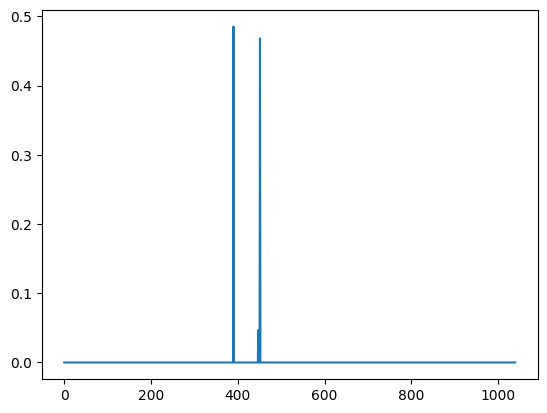

In [ ]:
plt.plot([i for i in range(len(pitcher_strat))], pitcher_strat)
plt.show()

In [ ]:
pitches_list = []
ti = []
for t in tunnel_indices:
  for p in pitches:
    ti.append(t)
    pitches_list.append(p)

pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': pitcher_strat})
pitcher_df = pitcher_df.merge(igrid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft']], how = 'inner', on=['tunnel_index', 'pitch_type'])

In [ ]:
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-5, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft
390,1597,SI,0.485317,0.190909,4.563636,0.325509,2.690823
447,1654,SL,0.046508,0.318182,4.690909,-0.289024,2.229577
451,1655,SL,0.468158,0.445455,4.690909,-0.055467,2.229577


In [ ]:
#get the corresponding strategies for each of those tunnels for the batter
batter_strats = dict()
for ti in pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0, 'tunnel_index']:
  batter_strats.update({ti: batter_strat[ti*2:2*ti+2]})

In [ ]:
batter_strats

{1597: array([9.99999816e-01, 1.83881643e-07]),
 1654: array([9.99999836e-01, 1.63717847e-07]),
 1655: array([9.99999802e-01, 1.97556099e-07])}

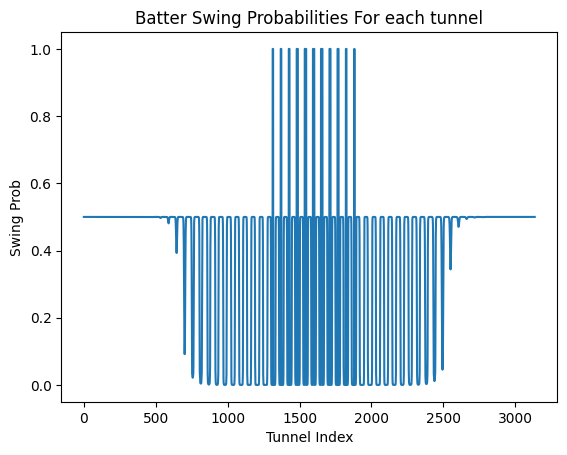

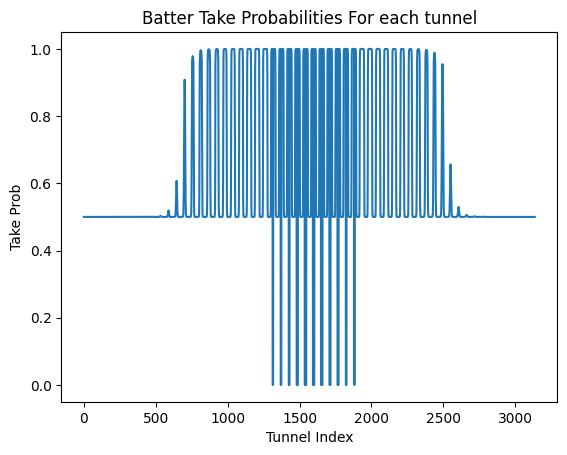

In [ ]:
plt.plot([i for i in range(A.shape[1]//2)],batter_strat[::2])
plt.title('Batter Swing Probabilities For each tunnel')
plt.xlabel('Tunnel Index')
plt.ylabel('Swing Prob')
plt.show()

plt.plot([i for i in range(A.shape[1]//2)],batter_strat[1::2])
plt.title('Batter Take Probabilities For each tunnel')
plt.xlabel('Tunnel Index')
plt.ylabel('Take Prob')
plt.show()

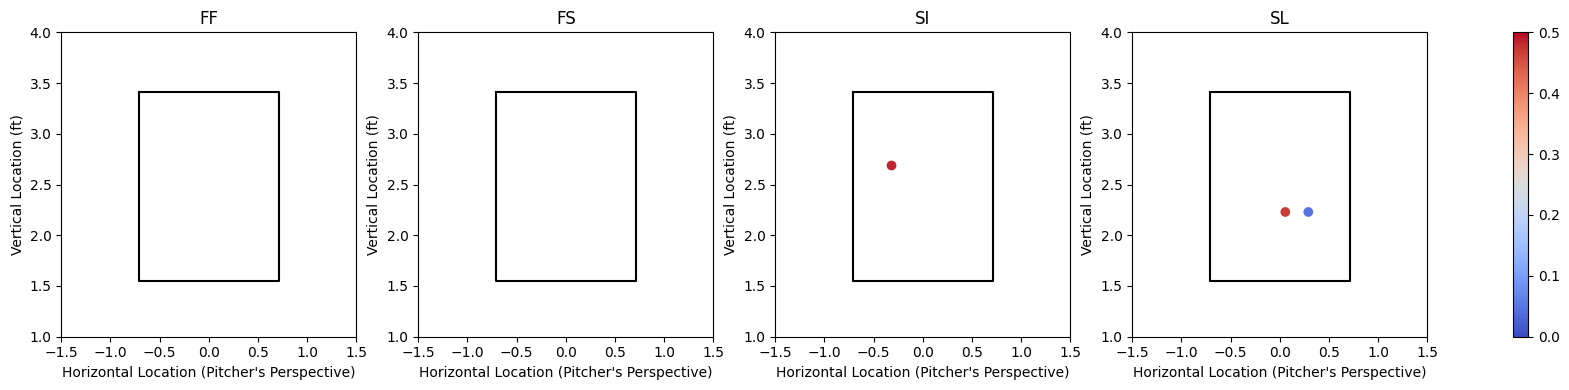

In [ ]:
#plot
num_pitches = len(pitches)
fig, axes= plt.subplots(nrows = 1, ncols = num_pitches, figsize = (18,4))
for i in range(num_pitches):
  ax = axes.flat[i]
  d = pitcher_df.loc[pitcher_df.pitch_type == pitches[i]]
  d = d.loc[d.equilibrium_usage_rate > 0]
  c = ax.scatter(-1*d.plate_x_ft.values, d.plate_z_ft.values, c = d.equilibrium_usage_rate.values, cmap = 'coolwarm', vmin = 0, vmax = 0.5)
  mid = 0.5 * d.equilibrium_usage_rate.max()
  #plot the standard strize zone as well
  ax.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
  ax.set_xlabel("Horizontal Location (Pitcher's Perspective)")
  ax.set_ylabel('Vertical Location (ft)')
  ax.set_xlim(-1.5,1.5)
  ax.set_ylim(1,4)
  ax.set_title(pitches[i])
plt.tight_layout()
fig.colorbar(c,ax=axes.ravel().tolist())

plt.show()

In [ ]:
#look at the tunnel on the previous pitch that Chapman threw to see if this game has learned the tunneling strategy where a player throws two consecutive pitches in similar tunnels. 
penultimate = bross_pa.loc[bross_pa.pitch_number == 9]
penultimate[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(penultimate[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)

penultimate[['tunnel_x', 'tunnel_y', 'tunnel_z']] = trace_decision_trajectory(penultimate)

In [ ]:
penultimate[['pitch_type', 'pitch_number', 'outcome', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft']]

,pitch_type,pitch_number,outcome,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft
176,FF,9,3,0.271246,4.330123,0.32,2.51


In [ ]:
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft
390,1597,SI,0.485317,0.190909,4.563636,0.325509,2.690823
447,1654,SL,0.046508,0.318182,4.690909,-0.289024,2.229577
451,1655,SL,0.468158,0.445455,4.690909,-0.055467,2.229577


#### **Anderson vs Mookie**

In [ ]:
#get the at bat from pybaseball
game = pybaseball.statcast(start_dt = '2020-10-27', end_dt = '2020-10-27')

game = game[needed_columns]
game = organize_data(game)

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


In [ ]:
pa = game.loc[(game.batter == batters[1]) & (game.pitcher == pitchers[1])]
pa['batter_index'] = batter_idxs[1]

#run the model on the pa
pa = pa[::-1]
pa['plate_x_ft'] = pa.plate_x 
pa['plate_z_ft'] = pa.plate_z 
pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)
#loop through the pitches
pred_outcomes = torch.empty((1,9)).to(device)
x_data = torch.tensor(pa[features].values.astype(float), dtype = torch.float).to(device)
y_data = torch.tensor(pa.outcome.values, dtype = torch.long).to(device)
h0 = model.init_hidden().to(device)
for p in range(pa.shape[0]):
  yhat, h1 = model(x_data[p].unsqueeze(0), h0, y_data[p].unsqueeze(0))
  pred_outcomes = torch.cat((pred_outcomes, yhat), dim = 0)
  h0 = h1 
  if p == pa.shape[0] - 2:
    #save the hidden state after the second to last pitch 
    h = h0.clone() ### bug fix 

#now softmax the predictions and append onto the bross pa 
ypreds = nn.functional.softmax(pred_outcomes[1:,:], dim = 1).detach().cpu().numpy()
pa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = ypreds 

#and calculate the utilities for each of those pitches 
pa = get_utilities(pa)

In [ ]:
#now we can see the utilities of all of those pitches, and most interestingly the utility of the last pitch
pa[['player_name', 'batter', 'pitch_type', 'balls', 'strikes','plate_x', 'plate_z', 'plate_x_ft', 'plate_z_ft', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'swing_utility', 'take_utility']]

,player_name,batter,pitch_type,balls,strikes,plate_x,plate_z,plate_x_ft,plate_z_ft,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility
250,"Anderson, Nick",605141,FF,0,0,1.442304,0.928616,1.26,3.19,0,0.977774,0.002205,0.008487,0.008363,0.002272,0.000748,0.000118,0.000005,0.000027,-0.043662,0.033827
244,"Anderson, Nick",605141,FF,1,0,1.596351,0.539995,1.39,2.81,0,0.962326,0.000915,0.017599,0.014193,0.003655,0.001091,0.000174,0.000007,0.000040,-0.056432,0.062893
230,"Anderson, Nick",605141,FF,2,0,0.375830,0.539995,0.36,2.81,6,0.000797,0.293805,0.165113,0.337587,0.131421,0.035943,0.015856,0.001682,0.017796,-0.044742,-0.061535


In [ ]:
#we calculated the hidden state after the 2nd pitch, so the pitch right before that last pitch, in the previous cell, so we can use that to get the utilities for all of Anderson's pitches
#given the prior sequence
igrid = initial_grid(batter_idxs[1], pitchers[1], h, bhand = 1.,phand = 1., balls = 2, strikes = 0)

In [ ]:
#now get the A matrix for this game 
pitches = pitch_usages.loc[pitch_usages.pitcher_id==pitchers[1], 'pitch_type'].unique()
tunnel_indices = igrid.loc[(igrid.plate_x_ft >= -1.5) & (igrid.plate_x_ft <= 1.5) & (igrid.plate_z_ft >= 1) & (igrid.plate_z_ft <= 4), 'tunnel_index'].unique()
execution_score =  {'CU': 0.604, 'FF': 0.521}

#initialize A
A = get_A_for_tunnel(igrid, tunnel_indices[0], pitches[0], 0.6)
for t in tunnel_indices:
  for p in pitches:
    A = np.vstack((A, get_A_for_tunnel(igrid, t, p, execution_score[p])))
A = A[1:,:]

In [ ]:
#now solve the game 
batter_strat, pitcher_strat, util = get_strategies(A)

     pcost       dcost       gap    pres   dres   k/t
 0:  3.6843e-03  3.6843e-03  1e+04  9e+01  4e+02  1e+00
 1:  3.5533e-01  2.4734e+00  5e+02  1e+01  6e+01  2e+00
 2:  3.6957e-01  5.0296e-01  5e+00  1e-01  7e-01  1e-01
 3:  8.2552e-02  1.0073e-01  7e-01  2e-02  1e-01  2e-02
 4:  3.5450e-02  4.4322e-02  4e-01  1e-02  6e-02  9e-03
 5:  3.8363e-02  4.6971e-02  4e-01  1e-02  6e-02  9e-03
 6:  3.9190e-02  4.5138e-02  3e-01  9e-03  5e-02  6e-03
 7:  3.2567e-02  3.4328e-02  2e-01  4e-03  2e-02  2e-03
 8:  2.9079e-02  2.9906e-02  8e-02  2e-03  1e-02  9e-04
 9:  2.7308e-02  2.7733e-02  5e-02  1e-03  7e-03  4e-04
10:  2.5888e-02  2.5973e-02  3e-02  7e-04  4e-03  9e-05
11:  2.5125e-02  2.5141e-02  5e-03  1e-04  7e-04  2e-05
12:  2.4945e-02  2.4950e-02  2e-03  4e-05  2e-04  5e-06
13:  2.4860e-02  2.4860e-02  2e-04  5e-06  3e-05  2e-07
14:  2.4850e-02  2.4850e-02  7e-05  2e-06  9e-06  6e-08
15:  2.4849e-02  2.4849e-02  5e-05  1e-06  7e-06  3e-08
16:  2.4845e-02  2.4845e-02  6e-06  1e-07  8e-07  

In [ ]:
np.allclose(1,pitcher_strat.sum()), util

(True, array([-0.02484527]))

In [ ]:
pitches_list = []
ti = []
for t in tunnel_indices:
  for p in pitches:
    ti.append(t)
    pitches_list.append(p)

pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': pitcher_strat})
pitcher_df = pitcher_df.merge(igrid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft']], how = 'inner', on=['tunnel_index', 'pitch_type'])

#zero out the really small probabilities
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-5, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft
63,1594,FF,0.596313,-0.190909,4.563636,0.148023,2.382240
132,1761,CU,0.403676,-0.318182,4.945455,0.121270,2.173324


In [ ]:
#get the corresponding strategies for each of those tunnels for the batter
batter_strats = dict()
for ti in pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0, 'tunnel_index']:
  batter_strats.update({ti: batter_strat[ti*2:2*ti+2]})

batter_strats

{1594: array([9.99997622e-01, 2.37844472e-06]),
 1761: array([9.99996801e-01, 3.19933473e-06])}

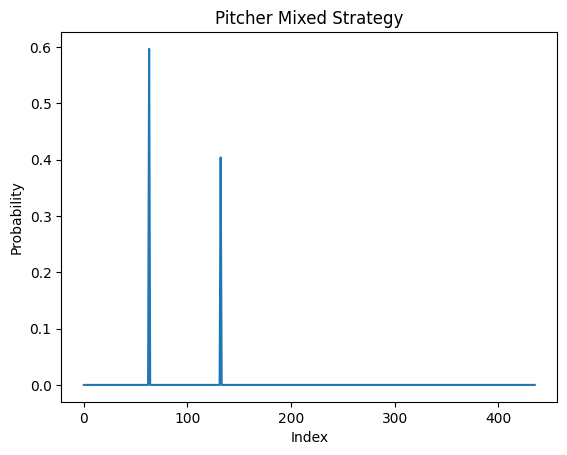

In [ ]:
plt.plot([i for i in range(len(pitcher_strat))], pitcher_strat)
plt.title('Pitcher Mixed Strategy')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.show()

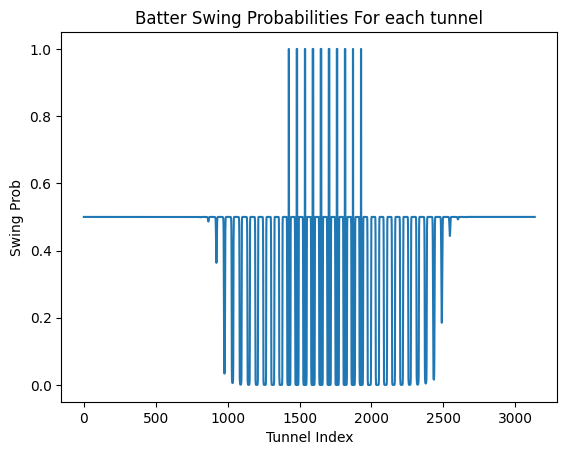

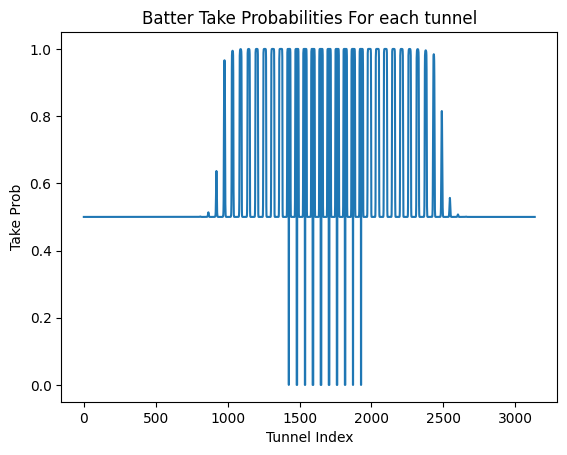

In [ ]:
plt.plot([i for i in range(A.shape[1]//2)],batter_strat[::2])
plt.title('Batter Swing Probabilities For each tunnel')
plt.xlabel('Tunnel Index')
plt.ylabel('Swing Prob')
plt.show()

plt.plot([i for i in range(A.shape[1]//2)],batter_strat[1::2])
plt.title('Batter Take Probabilities For each tunnel')
plt.xlabel('Tunnel Index')
plt.ylabel('Take Prob')
plt.show()

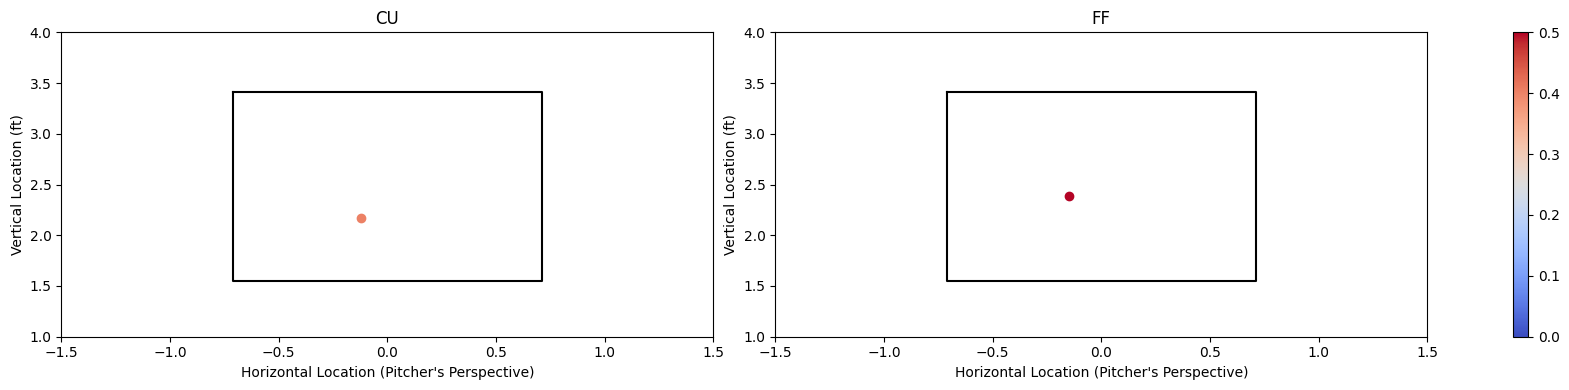

In [ ]:
#plot
num_pitches = len(pitches)
fig, axes= plt.subplots(nrows = 1, ncols = num_pitches, figsize = (18,4))
for i in range(num_pitches):
  ax = axes.flat[i]
  d = pitcher_df.loc[pitcher_df.pitch_type == pitches[i]]
  d = d.loc[d.equilibrium_usage_rate > 0]
  c = ax.scatter(-1*d.plate_x_ft.values, d.plate_z_ft.values, c = d.equilibrium_usage_rate.values, cmap = 'coolwarm', vmin = 0, vmax = 0.5)
  mid = 0.5 * d.equilibrium_usage_rate.max()
  #plot the standard strize zone as well
  ax.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
  ax.set_xlabel("Horizontal Location (Pitcher's Perspective)")
  ax.set_ylabel('Vertical Location (ft)')
  ax.set_xlim(-1.5,1.5)
  ax.set_ylim(1,4)
  ax.set_title(pitches[i])
plt.tight_layout()
fig.colorbar(c,ax=axes.ravel().tolist())

plt.show()

In [ ]:
#look at the tunnel on the previous pitch that Anderson threw to see if this game has learned the tunneling strategy where a player throws two consecutive pitches in similar tunnels. Doubtful in this game since the previous 
#pitches were balls, and we wouldn't want Anderson to throw another ball.
penultimate = pa.loc[pa.pitch_number == 2]
penultimate[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(penultimate[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)

penultimate[['tunnel_x', 'tunnel_y', 'tunnel_z']] = trace_decision_trajectory(penultimate)

In [ ]:
penultimate[['pitch_type', 'pitch_number', 'outcome', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft']]

,pitch_type,pitch_number,outcome,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft
244,FF,2,0,0.515186,4.704794,1.39,2.81


In [ ]:
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft
63,1594,FF,0.596313,-0.190909,4.563636,0.148023,2.382240
132,1761,CU,0.403676,-0.318182,4.945455,0.121270,2.173324


#### **Jansen vs Phillips**

In [ ]:
#get the at bat from pybaseball
game = pybaseball.statcast(start_dt = '2020-10-24', end_dt = '2020-10-24')

game = game[needed_columns]
game = organize_data(game)

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


In [ ]:
pa = game.loc[(game.batter == batters[2]) & (game.pitcher == pitchers[2])]
pa['batter_index'] = batter_idxs[2]

#run the model on the pa
pa = pa[::-1]
pa['plate_x_ft'] = pa.plate_x 
pa['plate_z_ft'] = pa.plate_z 
pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)
#loop through the pitches
pred_outcomes = torch.empty((1,9)).to(device)
x_data = torch.tensor(pa[features].values.astype(float), dtype = torch.float).to(device)
y_data = torch.tensor(pa.outcome.values, dtype = torch.long).to(device)
h0 = model.init_hidden().to(device)
for p in range(pa.shape[0]):
  yhat, h1 = model(x_data[p].unsqueeze(0), h0, y_data[p].unsqueeze(0))
  pred_outcomes = torch.cat((pred_outcomes, yhat), dim = 0)
  h0 = h1 
  if p == pa.shape[0] - 2:
    #save the hidden state after the second to last pitch 
    h = h0.clone() ### bug fix, need to clone h0

#now softmax the predictions and append onto the bross pa 
ypreds = nn.functional.softmax(pred_outcomes[1:,:], dim = 1).detach().cpu().numpy()
pa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = ypreds 

#and calculate the utilities for each of those pitches 
pa = get_utilities(pa)

In [ ]:
#now we can see the utilities of all of those pitches, and most interestingly the utility of the last pitch
pa[['player_name', 'batter', 'pitch_type', 'balls', 'strikes','plate_x', 'plate_z', 'plate_x_ft', 'plate_z_ft', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'swing_utility', 'take_utility']]

,player_name,batter,pitch_type,balls,strikes,plate_x,plate_z,plate_x_ft,plate_z_ft,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility
137,"Jansen, Kenley",621433,FC,0,0,1.146061,-0.073618,1.01,2.21,0,0.359006,0.031942,0.126646,0.338238,0.106224,0.027180,0.007599,0.000437,0.002729,-0.044253,0.027709
132,"Jansen, Kenley",621433,FC,1,0,0.980166,0.785439,0.87,3.05,1,0.338521,0.105583,0.069858,0.310959,0.130165,0.030707,0.009224,0.000622,0.004362,-0.060000,0.036135
130,"Jansen, Kenley",621433,SI,1,1,-1.046135,-0.462239,-0.84,1.83,1,0.414153,0.459284,0.022835,0.056786,0.031509,0.010899,0.003123,0.000260,0.001151,-0.031176,-0.011523
119,"Jansen, Kenley",621433,FC,1,2,0.494327,0.130920,0.46,2.41,5,0.000996,0.026303,0.060885,0.420487,0.337110,0.101409,0.029200,0.002181,0.021429,0.037448,-0.196806


In [ ]:
#we calculated the hidden state after the 3rd pitch, so the pitch right before that last pitch, in the previous cell, so we can use that to get the utilities for all of Anderson's pitches
#given the prior sequence
igrid = initial_grid(batter_idxs[2], pitchers[2], h, bhand = 0.,phand = 1., balls = 1, strikes = 2)

In [ ]:
#now get the A matrix for this game 
pitches = pitch_usages.loc[pitch_usages.pitcher_id==pitchers[2], 'pitch_type'].unique()
tunnel_indices = igrid.loc[(igrid.plate_x_ft >= -1.5) & (igrid.plate_x_ft <= 1.5) & (igrid.plate_z_ft >= 1) & (igrid.plate_z_ft <= 4), 'tunnel_index'].unique()
execution_score =  {'FC': 0.51, 'SI':0.61, 'SL': 0.636}

#initialize A
A = get_A_for_tunnel(igrid, tunnel_indices[0], pitches[0], 0.6)
for t in tunnel_indices:
  for p in pitches:
    A = np.vstack((A, get_A_for_tunnel(igrid, t, p, execution_score[p])))
A = A[1:,:]

In [ ]:
#now solve the game 
batter_strat, pitcher_strat, util = get_strategies(A)

     pcost       dcost       gap    pres   dres   k/t
 0:  4.3732e-02  4.3732e-02  1e+04  9e+01  8e+02  1e+00
 1:  3.9599e-01  2.5099e+00  6e+02  1e+01  1e+02  2e+00
 2:  4.1751e-01  5.5103e-01  5e+00  1e-01  1e+00  1e-01
 3:  1.6971e-01  1.8782e-01  8e-01  2e-02  2e-01  2e-02
 4:  3.0695e-02  3.4222e-02  2e-01  5e-03  5e-02  4e-03
 5:  3.2576e-02  3.5230e-02  2e-01  5e-03  4e-02  3e-03
 6:  2.7345e-02  2.8667e-02  1e-01  3e-03  3e-02  1e-03
 7:  2.3466e-02  2.4136e-02  7e-02  2e-03  2e-02  7e-04
 8:  2.1680e-02  2.2051e-02  5e-02  1e-03  1e-02  4e-04
 9:  2.0125e-02  2.0279e-02  2e-02  6e-04  6e-03  2e-04
10:  1.9378e-02  1.9413e-02  1e-02  4e-04  3e-03  4e-05
11:  1.8941e-02  1.8952e-02  6e-03  2e-04  1e-03  1e-05
12:  1.8746e-02  1.8748e-02  2e-03  6e-05  6e-04  3e-06
13:  1.8679e-02  1.8680e-02  1e-03  3e-05  3e-04  7e-07
14:  1.8612e-02  1.8612e-02  2e-04  5e-06  5e-05  1e-07
15:  1.8600e-02  1.8600e-02  6e-05  2e-06  2e-05  3e-08
16:  1.8600e-02  1.8600e-02  5e-05  1e-06  1e-05  

In [ ]:
np.allclose(1,pitcher_strat.sum()), util

(True, array([-0.01859442]))

In [ ]:
pitches_list = []
ti = []
for t in tunnel_indices:
  for p in pitches:
    ti.append(t)
    pitches_list.append(p)

pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': pitcher_strat})
pitcher_df = pitcher_df.merge(igrid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft', 'swing_utility', 'take_utility']], how = 'inner', on=['tunnel_index', 'pitch_type'])

#zero out the really small probabilities
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-4, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft,swing_utility,take_utility
120,1476,FC,0.061391,-0.954545,4.309091,-0.355441,1.885162,0.041303,-0.199718
133,1480,SI,0.143500,-0.445455,4.309091,-0.047720,2.069117,0.040881,-0.204306
136,1481,SI,0.146459,-0.318182,4.309091,0.185837,2.069117,0.049258,-0.203678
170,1536,SL,0.461512,-0.445455,4.436364,0.609293,1.058913,-0.108560,0.045690
172,1537,SI,0.033528,-0.318182,4.436364,0.185837,2.298602,0.043530,-0.203885
307,1758,SI,0.089608,-0.700000,4.945455,-0.514835,3.216538,-0.041905,-0.113216
343,1814,SI,0.030203,-0.700000,5.072727,-0.514835,3.446022,-0.064159,0.013011
410,1924,SL,0.007258,-0.954545,5.327273,-0.324936,2.665302,0.048072,-0.203946
413,1925,SL,0.026530,-0.827273,5.327273,-0.091378,2.665302,0.067221,-0.204741


In [ ]:
#get the corresponding strategies for each of those tunnels for the batter
batter_strats = dict()
for ti in pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0, 'tunnel_index']:
  batter_strats.update({ti: batter_strat[ti*2:2*ti+2]})

batter_strats

{1476: array([5.10320969e-06, 9.99994897e-01]),
 1480: array([9.99998480e-01, 1.51952918e-06]),
 1481: array([9.99996728e-01, 3.27214732e-06]),
 1536: array([9.99999503e-01, 4.97194247e-07]),
 1537: array([9.99998870e-01, 1.12978308e-06]),
 1758: array([9.99999864e-01, 1.36036802e-07]),
 1814: array([9.99999560e-01, 4.39817388e-07]),
 1924: array([2.47613449e-05, 9.99975239e-01]),
 1925: array([5.70542875e-05, 9.99942946e-01])}

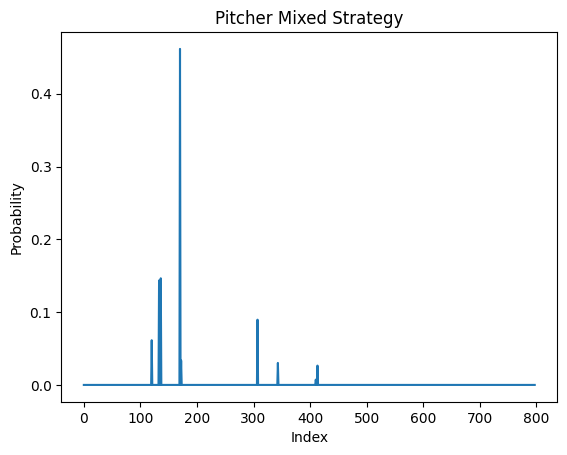

In [ ]:
plt.plot([i for i in range(len(pitcher_strat))], pitcher_strat)
plt.title('Pitcher Mixed Strategy')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.show()

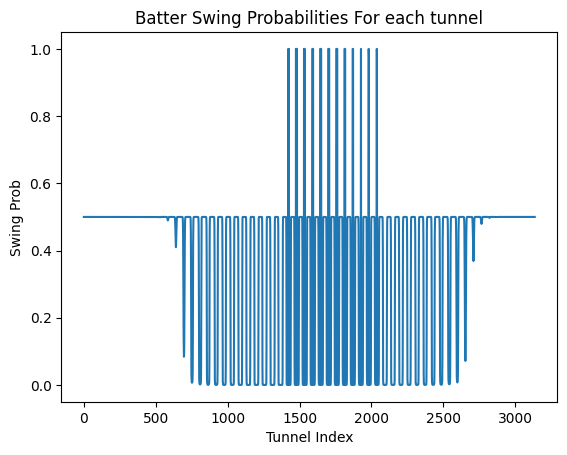

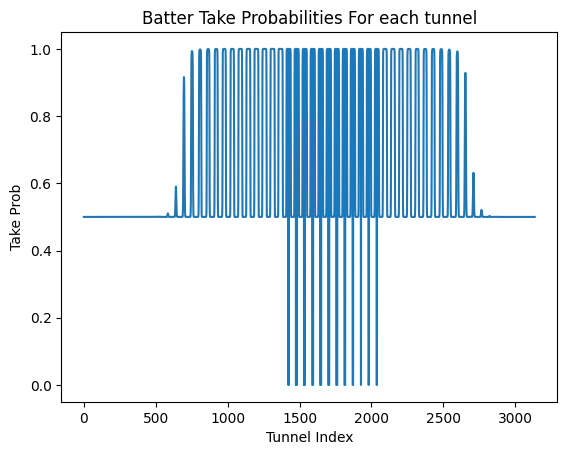

In [ ]:
plt.plot([i for i in range(A.shape[1]//2)],batter_strat[::2])
plt.title('Batter Swing Probabilities For each tunnel')
plt.xlabel('Tunnel Index')
plt.ylabel('Swing Prob')
plt.show()

plt.plot([i for i in range(A.shape[1]//2)],batter_strat[1::2])
plt.title('Batter Take Probabilities For each tunnel')
plt.xlabel('Tunnel Index')
plt.ylabel('Take Prob')
plt.show()

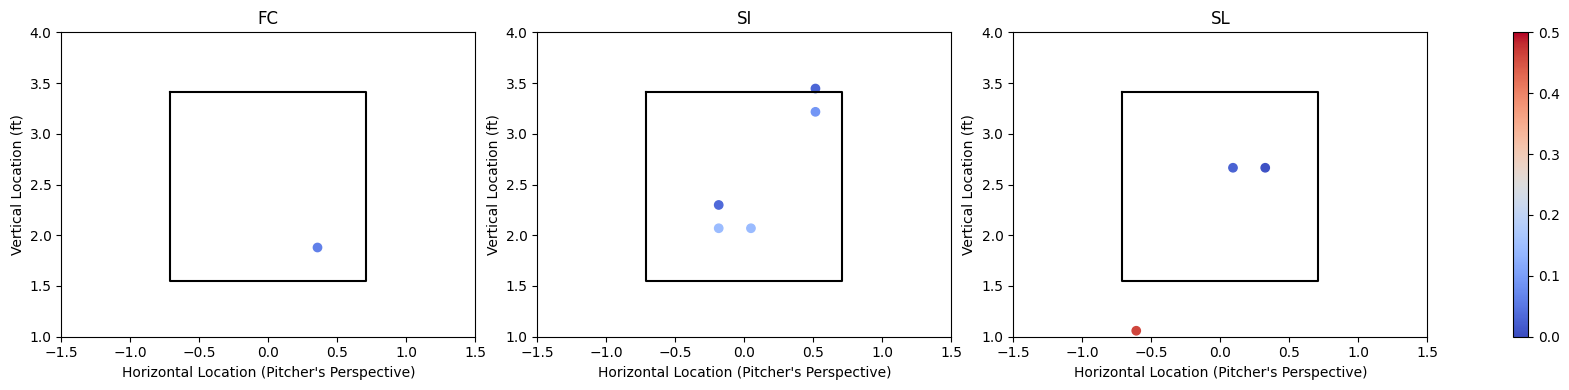

In [ ]:
#plot
num_pitches = len(pitches)
fig, axes= plt.subplots(nrows = 1, ncols = num_pitches, figsize = (18,4))
for i in range(num_pitches):
  ax = axes.flat[i]
  d = pitcher_df.loc[pitcher_df.pitch_type == pitches[i]]
  d = d.loc[d.equilibrium_usage_rate > 0]
  c = ax.scatter(-1*d.plate_x_ft.values, d.plate_z_ft.values, c = d.equilibrium_usage_rate.values, cmap = 'coolwarm', vmin = 0, vmax = 0.5)
  mid = 0.5 * d.equilibrium_usage_rate.max()
  #plot the standard strize zone as well
  ax.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
  ax.set_xlabel("Horizontal Location (Pitcher's Perspective)")
  ax.set_ylabel('Vertical Location (ft)')
  ax.set_xlim(-1.5,1.5)
  ax.set_ylim(1,4)
  ax.set_title(pitches[i])
plt.tight_layout()
fig.colorbar(c,ax=axes.ravel().tolist())

plt.show()

In [ ]:
#Phillips strategy in the tunnel with the low slider, tunnel 1536, is to pretty much always swing. That seems odd 
igrid.loc[igrid.tunnel_index == 1536]

,release_speed,mx,mz,bat_handR,pit_handR,release_spin_rate,tunnel_x,tunnel_z,tunnel_index,batter_index,pitcher_id,pitch_type,balls,strikes,pfx_x,pfx_z,release_pos_x,release_pos_z,plate_x,plate_z,plate_x_ft,plate_z_ft,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,actual_run_value
1536,0.576707,0.881953,1.029020,0.0,1.0,1.140644,-0.445455,4.436364,1536,547,445276,FC,1,2,0.661397,1.408429,-1.339524,6.574298,0.635088,-0.171135,0.578788,2.114646,0.006032,0.052761,0.053657,0.407142,0.336060,0.098813,0.026803,0.002184,0.016548,0.028979,-0.180147,NaN
4672,0.800049,-0.429351,1.287916,0.0,1.0,0.155707,-0.445455,4.436364,1536,547,445276,SI,1,2,-0.488189,1.601738,-1.171312,6.485896,-0.107306,0.016994,-0.047720,2.298602,0.000474,0.070248,0.132441,0.462787,0.212534,0.066891,0.026781,0.002368,0.025475,0.033968,-0.204311,NaN
7808,-1.183171,0.639602,-1.549497,0.0,1.0,0.635130,-0.445455,4.436364,1536,547,445276,SL,1,2,0.448934,-0.516865,-1.483699,6.498464,0.671236,-1.250819,0.609293,1.058913,0.439265,0.000542,0.307936,0.183575,0.049497,0.014911,0.003401,0.000157,0.000716,-0.108560,0.045690,NaN


In [ ]:
#it looks like the swing utility for the other two pitches in that tunnel is fairly high, 0.03 for each, and the 
#take utility is really low, -0.18 and -0.2 for both, which makes the swing utility at that slider of just -0.1 look 
#not so bad. This tunnel also seems to be fairly close to the tunnels where Jansen is supposed to throw those 
#two sinkers in the middle of the zone. When you factor in execution scores, it's probably fair to say that Jansen is basically aiming 
#his slider and his sinker in a similar set of tunnels. Phillips' strategy is to swing in those tunnels because even though 
#it's bad to swing at the slider, it's much worse for him to not swing at the sinker, so he's banking on that. I imagine if Jansen threw his slider more 
#often, Phillips would start to swing less often in that tunnel. We can test this though: let's see if lowering the swing rate in that slider tunnel 
#improves utility. If it doesn't, we know that the batter can't improve by changing his strategy for that tunnel, so that actually is an equilibrium for 
#Phillips' given Jansesn's strategy.

In [ ]:
#original utility
print(pitcher_strat @ A @ batter_strat)
batter_strat2 = batter_strat.copy()
#adjust Phillips swing rate in that tunnel
utils = []
swing_rates = []
for i in range(100):
  batter_strat2[1536*2:2*1536+2] = np.array([1-0.01 * i, 0.01*i])
  swing_rates.append(1-0.01*i)
  utils.append(pitcher_strat @ A @ batter_strat2)

-0.01859430550219151


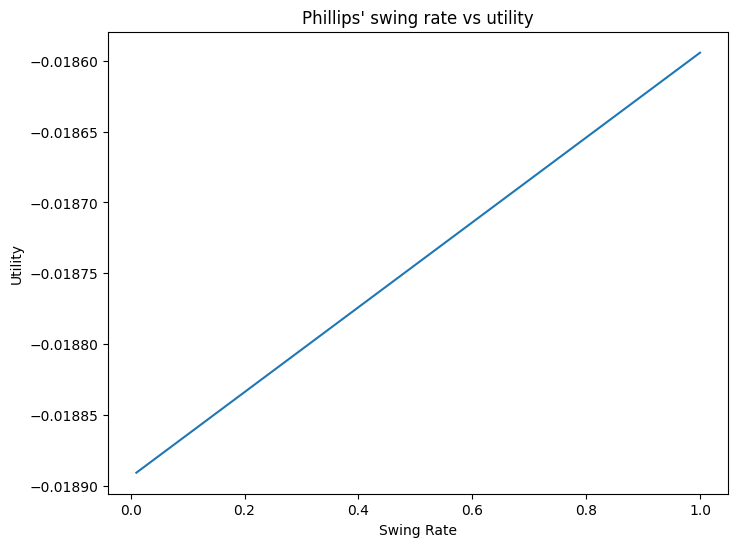

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(swing_rates, utils)
plt.xlabel('Swing Rate')
plt.ylabel('Utility')
plt.title("Phillips' swing rate vs utility")
plt.show()

In [ ]:
#look at the tunnel on the previous pitch that JAnsen threw to see if this game has learned the tunneling strategy where a player throws two consecutive pitches in similar tunnels.
penultimate = pa.loc[pa.pitch_number == 3]
penultimate[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(penultimate[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)

penultimate[['tunnel_x', 'tunnel_y', 'tunnel_z']] = trace_decision_trajectory(penultimate)

In [ ]:
penultimate[['pitch_type', 'pitch_number', 'outcome', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft']]

,pitch_type,pitch_number,outcome,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft
130,SI,3,1,-1.082386,4.066954,-0.84,1.83


In [ ]:
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft,swing_utility,take_utility
120,1476,FC,0.061391,-0.954545,4.309091,-0.355441,1.885162,0.041303,-0.199718
133,1480,SI,0.143500,-0.445455,4.309091,-0.047720,2.069117,0.040881,-0.204306
136,1481,SI,0.146459,-0.318182,4.309091,0.185837,2.069117,0.049258,-0.203678
170,1536,SL,0.461512,-0.445455,4.436364,0.609293,1.058913,-0.108560,0.045690
172,1537,SI,0.033528,-0.318182,4.436364,0.185837,2.298602,0.043530,-0.203885
307,1758,SI,0.089608,-0.700000,4.945455,-0.514835,3.216538,-0.041905,-0.113216
343,1814,SI,0.030203,-0.700000,5.072727,-0.514835,3.446022,-0.064159,0.013011
410,1924,SL,0.007258,-0.954545,5.327273,-0.324936,2.665302,0.048072,-0.203946
413,1925,SL,0.026530,-0.827273,5.327273,-0.091378,2.665302,0.067221,-0.204741


In [ ]:
#get the tunnel location for Jansen's actual pitch to plot with the other tunnels 
actual_pitch = pa.loc[pa.pitch_number == 4]
actual_pitch[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(actual_pitch[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)

actual_pitch[['tunnel_x', 'tunnel_y', 'tunnel_z']] = trace_decision_trajectory(actual_pitch)

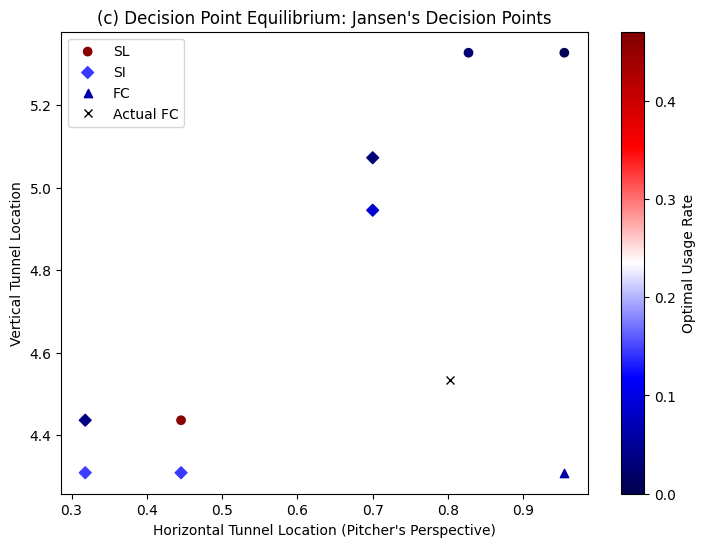

In [ ]:
#plot tunnels 
plt.figure(figsize = (8.5,6))
d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

fc = d.loc[d.pitch_type == 'FC']
si = d.loc[d.pitch_type == 'SI']
sl = d.loc[d.pitch_type == 'SL']
plt.scatter(-1*sl.tunnel_x.values, sl.tunnel_z.values, marker = 'o', label = 'SL', c = sl.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.47)
plt.scatter(-1*si.tunnel_x.values, si.tunnel_z.values, marker = 'D', label = 'SI', c = si.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.47)
c = plt.scatter(-1*fc.tunnel_x.values, fc.tunnel_z.values, marker = '^', label = 'FC', c = fc.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.47)
#plot the standard strize zone as well
#plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
#plot the actual pitch that Jansen threw 
plt.plot(-1*actual_pitch.tunnel_x.values[0], actual_pitch.tunnel_z.values[0], 'kx', label = "Actual FC")
plt.xlabel("Horizontal Tunnel Location (Pitcher's Perspective)")
plt.ylabel('Vertical Tunnel Location')
#plt.xlim(-1.5,1.5)
#plt.ylim(1,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
plt.legend()
plt.title("(c) Decision Point Equilibrium: Jansen's Decision Points")
plt.show()

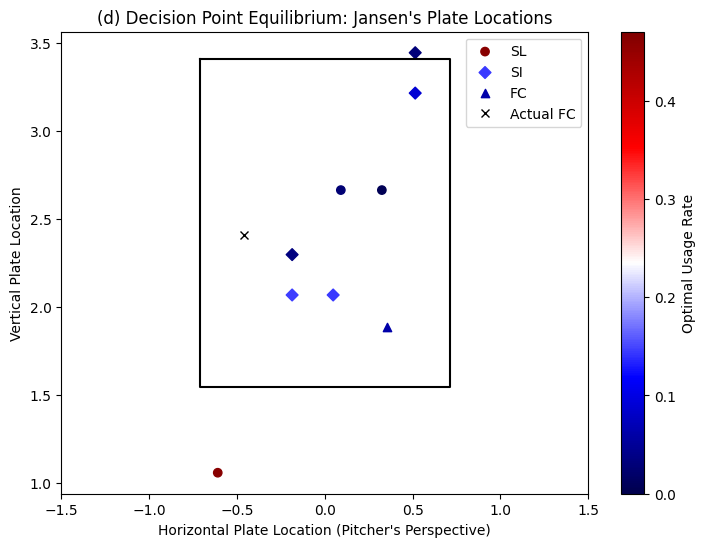

In [ ]:
#prettier plot for the paper 
plt.figure(figsize = (8.5,6))
d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

fc = d.loc[d.pitch_type == 'FC']
si = d.loc[d.pitch_type == 'SI']
sl = d.loc[d.pitch_type == 'SL']
plt.scatter(-1*sl.plate_x_ft.values, sl.plate_z_ft.values, marker = 'o', label = 'SL', c = sl.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.47)
plt.scatter(-1*si.plate_x_ft.values, si.plate_z_ft.values, marker = 'D', label = 'SI', c = si.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.47)
c = plt.scatter(-1*fc.plate_x_ft.values, fc.plate_z_ft.values, marker = '^', label = 'FC', c = fc.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.47)
#plot the standard strize zone as well
plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
#plot the actual pitch that Jansen threw 
plt.plot([-0.46], [2.41], 'kx', label = "Actual FC")
plt.xlabel("Horizontal Plate Location (Pitcher's Perspective)")
plt.ylabel('Vertical Plate Location')
plt.xlim(-1.5,1.5)
#plt.ylim(1,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
plt.legend()
plt.title("(d) Decision Point Equilibrium: Jansen's Plate Locations")
plt.show()

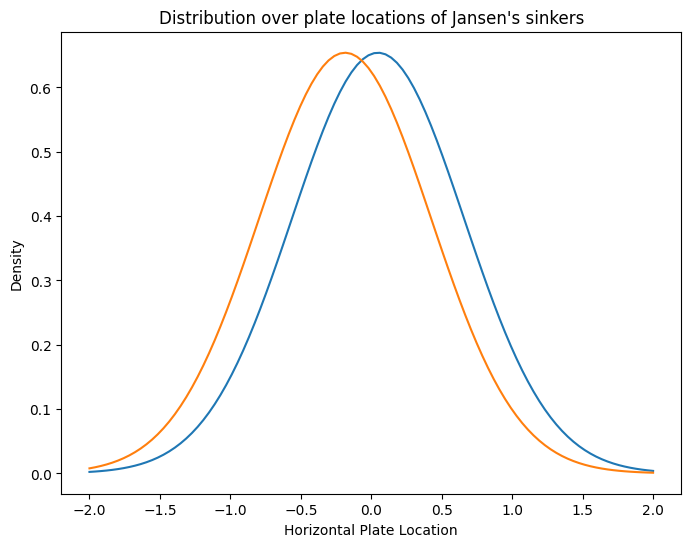

In [ ]:
#show that for the pairs of pitches here, when we factor in execution score, they end up being pretty much the same distributions
#first the two sinkers in the middle of teh zone 
from scipy.stats import norm 
dist1 = norm(loc = 0.047720, scale = 0.61)
dist2 = norm(loc = -0.185837, scale = 0.61)

plt.figure(figsize = (8,6))
x = np.linspace(-2,
                2, 100)
plt.plot(x, dist1.pdf(x))
plt.plot(x, dist2.pdf(x))
plt.xlabel('Horizontal Plate Location')
plt.ylabel('Density')
plt.title("Distribution over plate locations of Jansen's sinkers")
plt.show()

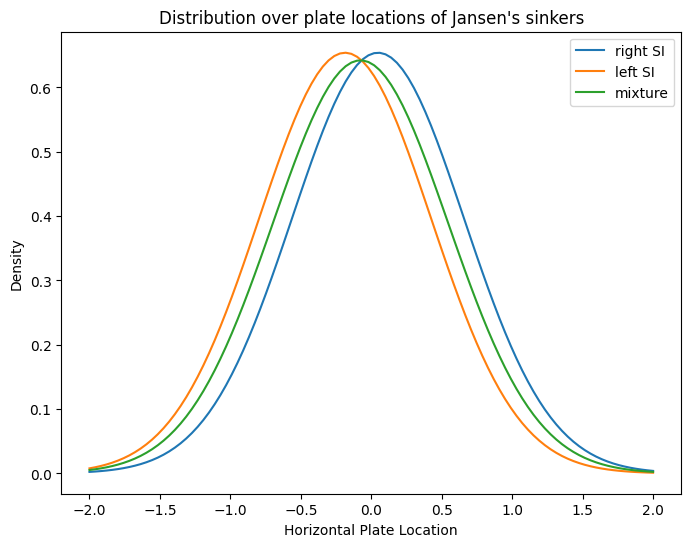

In [ ]:
#also plot the mixture model by weighing each distribution by it's relative likelihood
denom = 0.116855 + 0.131706
w1 = 0.116855 / denom 
w2 = 0.131706/denom
plt.figure(figsize = (8,6))
plt.plot(x, dist1.pdf(x), label = 'right SI')
plt.plot(x, dist2.pdf(x), label = 'left SI')
plt.plot(x, w1*dist1.pdf(x) + w2*dist2.pdf(x), label = 'mixture')
plt.xlabel('Horizontal Plate Location')
plt.ylabel('Density')
plt.title("Distribution over plate locations of Jansen's sinkers")
plt.legend()
plt.show()

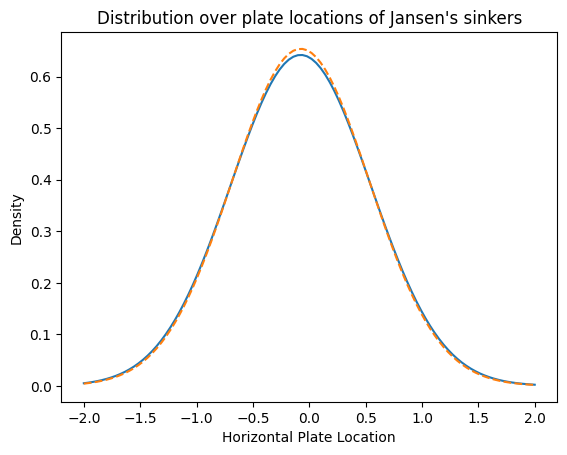

In [ ]:
mixed_norm = norm(loc = w1 * 0.047720 + w2*-0.185837, scale = 0.61)
plt.plot(x, w1*dist1.pdf(x) + w2*dist2.pdf(x))
plt.plot(x, mixed_norm.pdf(x), '--')
plt.xlabel('Horizontal Plate Location')
plt.ylabel('Density')
plt.title("Distribution over plate locations of Jansen's sinkers")
plt.show()

In [ ]:
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft,swing_utility,take_utility
120,1476,FC,0.061391,-0.954545,4.309091,-0.355441,1.885162,0.041303,-0.199718
133,1480,SI,0.143500,-0.445455,4.309091,-0.047720,2.069117,0.040881,-0.204306
136,1481,SI,0.146459,-0.318182,4.309091,0.185837,2.069117,0.049258,-0.203678
170,1536,SL,0.461512,-0.445455,4.436364,0.609293,1.058913,-0.108560,0.045690
172,1537,SI,0.033528,-0.318182,4.436364,0.185837,2.298602,0.043530,-0.203885
307,1758,SI,0.089608,-0.700000,4.945455,-0.514835,3.216538,-0.041905,-0.113216
343,1814,SI,0.030203,-0.700000,5.072727,-0.514835,3.446022,-0.064159,0.013011
410,1924,SL,0.007258,-0.954545,5.327273,-0.324936,2.665302,0.048072,-0.203946
413,1925,SL,0.026530,-0.827273,5.327273,-0.091378,2.665302,0.067221,-0.204741


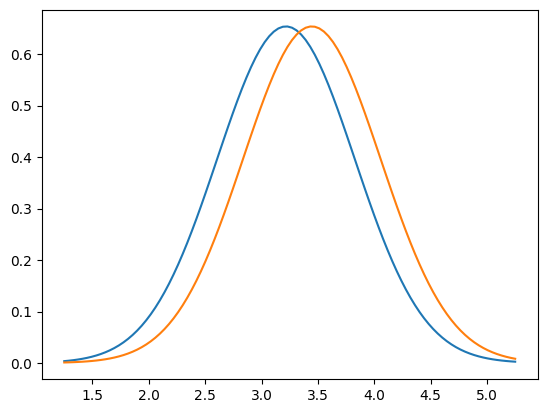

In [ ]:
#next the two sinkers at the top of the zone
dist1 = norm(loc = 3.216538, scale = 0.61)
dist2 = norm(loc = 3.446022, scale = 0.61)

x = np.linspace(1.25,5.25,100)
plt.plot(x, dist1.pdf(x))
plt.plot(x, dist2.pdf(x))
plt.show()

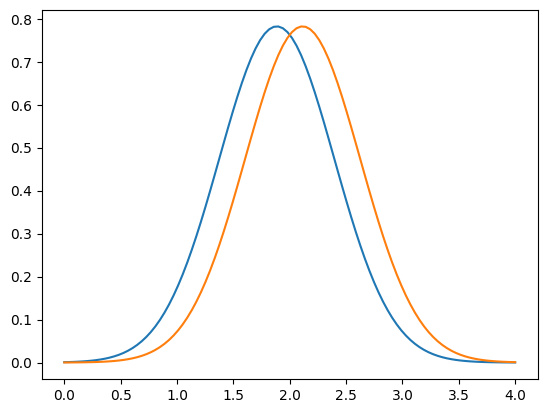

In [ ]:
#finally the two cutters
dist1 = norm(loc = 1.885162, scale = 0.51)
dist2 = norm(loc = 2.114646, scale = 0.51)

x = np.linspace(0,4,100)
plt.plot(x, dist1.pdf(x))
plt.plot(x, dist2.pdf(x))
plt.show()

#### **Nola vs Pena WS**

In [ ]:
#get the at bat from pybaseball
game = pybaseball.statcast(start_dt = '2022-11-02', end_dt = '2022-11-02')
game = game.loc[game.inning == 3]
game = game[needed_columns]
game = organize_data(game)

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


In [ ]:
pa = game.loc[(game.batter == 665161) & (game.pitcher == 605400)]
pa['batter_index'] = 7

#run the model on the pa
pa = pa[::-1]
pa['plate_x_ft'] = pa.plate_x 
pa['plate_z_ft'] = pa.plate_z 
pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)
#loop through the pitches
pred_outcomes = torch.empty((1,9)).to(device)
x_data = torch.tensor(pa[features].values.astype(float), dtype = torch.float).to(device)
y_data = torch.tensor(pa.outcome.values, dtype = torch.long).to(device)
h0 = model.init_hidden().to(device)
for p in range(pa.shape[0]):
  yhat, h1 = model(x_data[p].unsqueeze(0), h0, y_data[p].unsqueeze(0))
  pred_outcomes = torch.cat((pred_outcomes, yhat), dim = 0)
  h0 = h1 
  if p == pa.shape[0] - 2:
    #save the hidden state after the second to last pitch 
    h = h0.clone() ### Bug fix 

#now softmax the predictions and append onto the bross pa 
ypreds = nn.functional.softmax(pred_outcomes[1:,:], dim = 1).detach().cpu().numpy()
pa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = ypreds 

#and calculate the utilities for each of those pitches 
pa = get_utilities(pa)

In [ ]:
#now we can see the utilities of all of those pitches, and most interestingly the utility of the last pitch
pa[['player_name', 'batter', 'pitch_type', 'balls', 'strikes','plate_x', 'plate_z', 'plate_x_ft', 'plate_z_ft', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'swing_utility', 'take_utility']]

,player_name,batter,pitch_type,balls,strikes,plate_x,plate_z,plate_x_ft,plate_z_ft,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility
88,"Nola, Aaron",665161,KC,0,0,0.304732,-0.206567,0.3,2.08,1,0.001159,0.509641,0.106771,0.162176,0.152497,0.043851,0.012389,0.001372,0.010144,-0.017270,-0.042825
86,"Nola, Aaron",665161,CH,0,1,-0.512898,-1.004263,-0.39,1.3,0,0.361988,0.008030,0.396675,0.140989,0.064864,0.021310,0.004660,0.000387,0.001096,-0.050719,0.025068
85,"Nola, Aaron",665161,CH,1,1,0.292882,-0.359970,0.29,1.93,1,0.003562,0.208877,0.227855,0.237542,0.208201,0.068597,0.023811,0.003511,0.018045,-0.005573,-0.065038
82,"Nola, Aaron",665161,KC,1,2,-0.323303,-0.390651,-0.23,1.9,3,0.002059,0.038459,0.110379,0.374916,0.303478,0.101055,0.039544,0.003745,0.026365,0.053285,-0.193196
81,"Nola, Aaron",665161,CH,1,2,-0.181106,-1.065624,-0.11,1.24,0,0.233575,0.005415,0.310162,0.251296,0.138712,0.044717,0.011709,0.000982,0.003431,-0.065983,0.040291
79,"Nola, Aaron",665161,CH,2,2,0.008489,-1.771278,0.05,0.55,0,0.692356,0.000008,0.258333,0.033707,0.012000,0.003264,0.000289,0.000010,0.000033,-0.214855,0.097996
76,"Nola, Aaron",665161,KC,3,2,0.494327,-1.034943,0.46,1.27,2,0.135931,0.011993,0.297970,0.297848,0.187755,0.053111,0.011289,0.000769,0.003335,-0.157123,0.225167


In [ ]:
igrid = initial_grid(7, 605400, h, bhand = 1.,phand = 1., balls = 3, strikes = 2)

In [ ]:
#now get the A matrix for this game 
pitches = pitch_usages.loc[pitch_usages.pitcher_id==605400, 'pitch_type'].unique()
tunnel_indices = igrid.loc[(igrid.plate_x_ft >= -1.5) & (igrid.plate_x_ft <= 1.5) & (igrid.plate_z_ft >= 1) & (igrid.plate_z_ft <= 4), 'tunnel_index'].unique()
execution_score =  {'CH': 0.783, 'FC': 0.788, 'FF': 0.517, 'KC': 0.768, 'SI': 0.581}

#initialize A
A = get_A_for_tunnel(igrid, tunnel_indices[0], pitches[0], 0.6)
for t in tunnel_indices:
  for p in pitches:
    A = np.vstack((A, get_A_for_tunnel(igrid, t, p, execution_score[p])))
A = A[1:,:]

In [ ]:
#now solve the game 
batter_strat, pitcher_strat, util = get_strategies(A)

     pcost       dcost       gap    pres   dres   k/t
 0:  1.7288e-02  1.7288e-02  1e+04  1e+02  1e+03  1e+00
 1:  3.8103e-01  2.8044e+00  6e+02  1e+01  2e+02  3e+00
 2:  4.0587e-01  5.9448e-01  6e+00  2e-01  2e+00  2e-01
 3:  1.5015e-01  1.7516e-01  1e+00  3e-02  4e-01  3e-02
 4:  5.0274e-02  6.0906e-02  5e-01  2e-02  2e-01  1e-02
 5:  5.1451e-02  6.1391e-02  5e-01  2e-02  2e-01  1e-02
 6:  4.7104e-02  5.3312e-02  4e-01  1e-02  1e-01  6e-03
 7:  3.5258e-02  3.7789e-02  2e-01  6e-03  7e-02  3e-03
 8:  2.7036e-02  2.7708e-02  7e-02  2e-03  2e-02  7e-04
 9:  2.6209e-02  2.6688e-02  6e-02  2e-03  2e-02  5e-04
10:  2.4918e-02  2.5085e-02  4e-02  1e-03  1e-02  2e-04
11:  2.3684e-02  2.3722e-02  1e-02  4e-04  5e-03  4e-05
12:  2.3444e-02  2.3463e-02  1e-02  3e-04  3e-03  2e-05
13:  2.3117e-02  2.3122e-02  4e-03  1e-04  2e-03  7e-06
14:  2.3006e-02  2.3009e-02  3e-03  8e-05  9e-04  4e-06
15:  2.2890e-02  2.2891e-02  8e-04  2e-05  3e-04  1e-06
16:  2.2879e-02  2.2880e-02  7e-04  2e-05  2e-04  

In [ ]:
np.allclose(1,pitcher_strat.sum()), util

(True, array([-0.02282179]))

In [ ]:
pitches_list = []
ti = []
for t in tunnel_indices:
  for p in pitches:
    ti.append(t)
    pitches_list.append(p)

pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': pitcher_strat})
pitcher_df = pitcher_df.merge(igrid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft']], how = 'inner', on=['tunnel_index', 'pitch_type'])

#zero out the really small probabilities
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-5, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft
165,1310,FF,0.003249,-0.700000,3.927273,-0.182818,2.300276
169,1311,FF,0.061438,-0.572727,3.927273,0.050739,2.300276
213,1366,FF,0.194634,-0.700000,4.054545,-0.182818,2.529760
310,1478,KC,0.380394,-0.700000,4.309091,0.777245,1.678958
315,1479,SI,0.343210,-0.572727,4.309091,-0.084733,2.744421
441,1643,FF,0.017068,-1.081818,4.690909,-0.883490,3.677180


In [ ]:
#get the corresponding strategies for each of those tunnels for the batter
batter_strats = dict()
for ti in pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0, 'tunnel_index']:
  batter_strats.update({ti: batter_strat[ti*2:2*ti+2]})

batter_strats

{1310: array([9.99999839e-01, 1.61177720e-07]),
 1311: array([9.99999847e-01, 1.52736069e-07]),
 1366: array([9.99999868e-01, 1.31942282e-07]),
 1478: array([9.99999909e-01, 9.07582340e-08]),
 1479: array([9.99999865e-01, 1.34971290e-07]),
 1643: array([9.99997556e-01, 2.44434001e-06])}

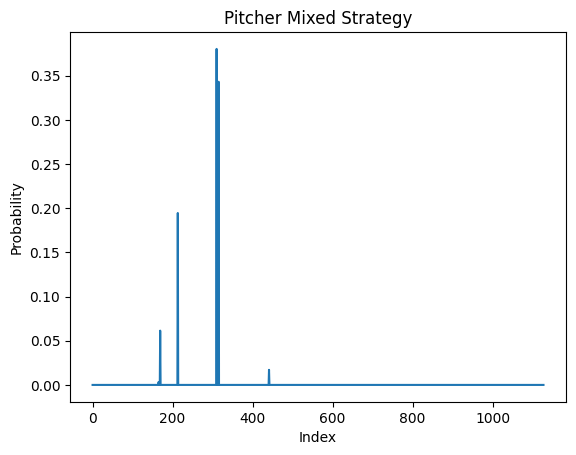

In [ ]:
plt.plot([i for i in range(len(pitcher_strat))], pitcher_strat)
plt.title('Pitcher Mixed Strategy')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.show()

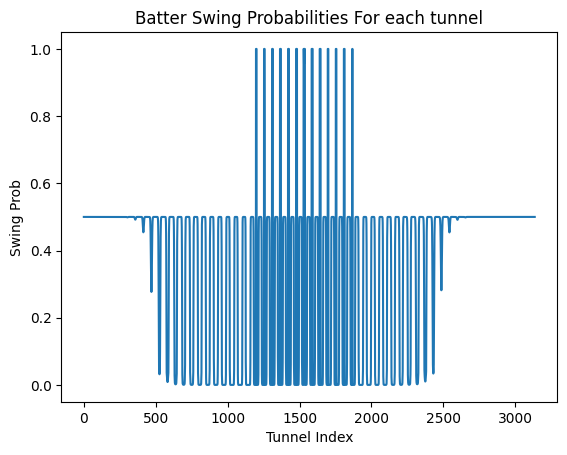

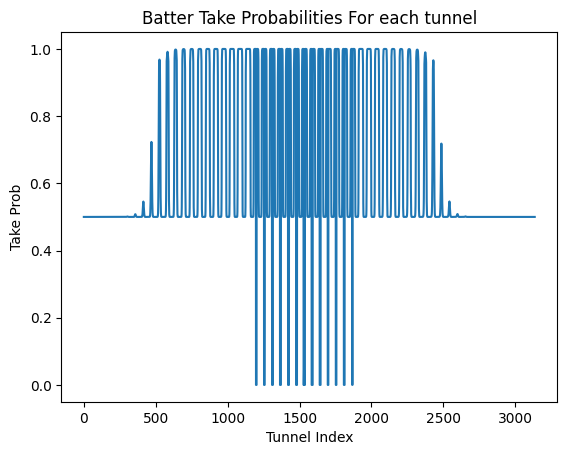

In [ ]:
plt.plot([i for i in range(A.shape[1]//2)],batter_strat[::2])
plt.title('Batter Swing Probabilities For each tunnel')
plt.xlabel('Tunnel Index')
plt.ylabel('Swing Prob')
plt.show()

plt.plot([i for i in range(A.shape[1]//2)],batter_strat[1::2])
plt.title('Batter Take Probabilities For each tunnel')
plt.xlabel('Tunnel Index')
plt.ylabel('Take Prob')
plt.show()

In [ ]:
#get the tunnel location for the actual pitch to plot with the other tunnels 
actual_pitch = pa.loc[pa.pitch_number == 7]
actual_pitch[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(actual_pitch[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)

actual_pitch[['tunnel_x', 'tunnel_y', 'tunnel_z']] = trace_decision_trajectory(actual_pitch)

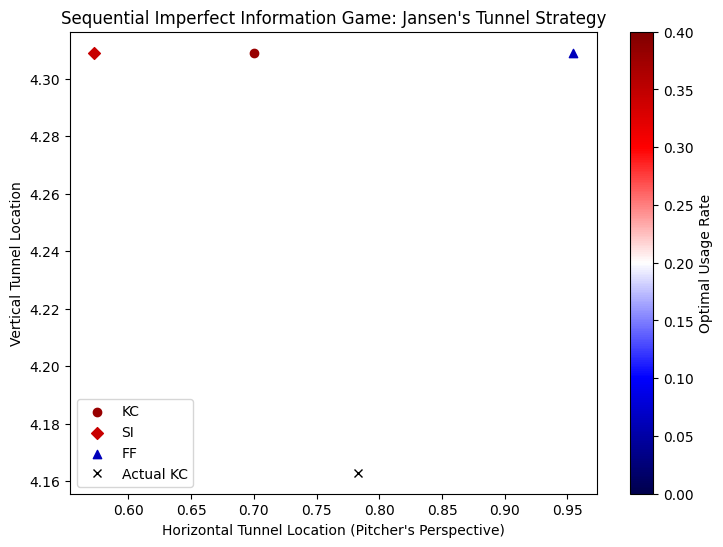

In [ ]:
#plot tunnels 
plt.figure(figsize = (8.5,6))
d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

ff = d.loc[d.pitch_type == 'FF']
si = d.loc[d.pitch_type == 'SI']
kc = d.loc[d.pitch_type == 'KC']
plt.scatter(-1*kc.tunnel_x.values, kc.tunnel_z.values, marker = 'o', label = 'KC', c = kc.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.4)
plt.scatter(-1*si.tunnel_x.values, si.tunnel_z.values, marker = 'D', label = 'SI', c = si.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.4)
c = plt.scatter(-1*fc.tunnel_x.values, fc.tunnel_z.values, marker = '^', label = 'FF', c = fc.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.4)
#plot the standard strize zone as well
#plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
#plot the actual pitch
plt.plot(-1*actual_pitch.tunnel_x.values[0], actual_pitch.tunnel_z.values[0], 'kx', label = "Actual KC")
plt.xlabel("Horizontal Tunnel Location (Pitcher's Perspective)")
plt.ylabel('Vertical Tunnel Location')
#plt.xlim(-1.5,1.5)
#plt.ylim(1,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
plt.legend()
plt.title("Sequential Imperfect Information Game: Jansen's Tunnel Strategy")
plt.show()

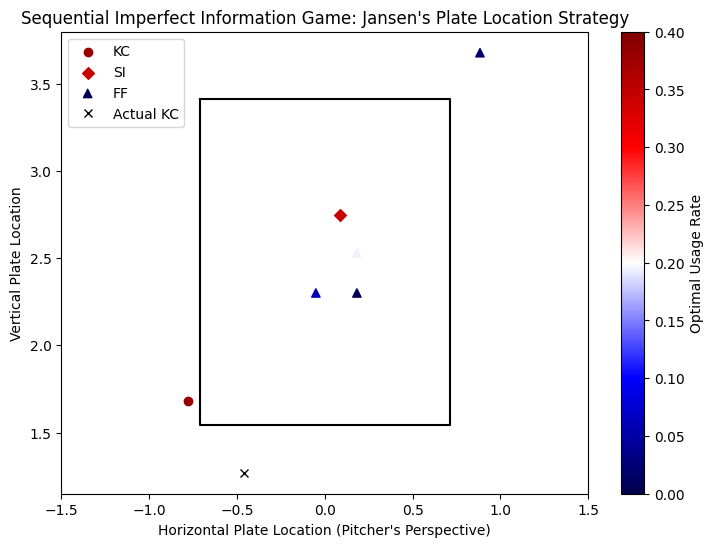

In [ ]:
#prettier plot for the paper 
plt.figure(figsize = (8.5,6))
d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

fc = d.loc[d.pitch_type == 'FF']
si = d.loc[d.pitch_type == 'SI']
sl = d.loc[d.pitch_type == 'KC']
plt.scatter(-1*sl.plate_x_ft.values, sl.plate_z_ft.values, marker = 'o', label = 'KC', c = sl.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.4)
plt.scatter(-1*si.plate_x_ft.values, si.plate_z_ft.values, marker = 'D', label = 'SI', c = si.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.4)
c = plt.scatter(-1*fc.plate_x_ft.values, fc.plate_z_ft.values, marker = '^', label = 'FF', c = fc.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.4)
#plot the standard strize zone as well
plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
#plot the actual pitch that Jansen threw 
plt.plot([-0.46], [1.27], 'kx', label = "Actual KC")
plt.xlabel("Horizontal Plate Location (Pitcher's Perspective)")
plt.ylabel('Vertical Plate Location')
plt.xlim(-1.5,1.5)
#plt.ylim(1,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
plt.legend()
plt.title("Sequential Imperfect Information Game: Jansen's Plate Location Strategy")
plt.show()

In [ ]:
#strategy on actual pitch tunnel
dists = np.sqrt((igrid.tunnel_x.values - actual_pitch.tunnel_x.values[0])**2 + (igrid.tunnel_z.values - actual_pitch.tunnel_z.values[0])**2)
igrid['dist'] = dists 
min_dist = np.min(dists)
igrid.loc[igrid.dist == min_dist]

,release_speed,mx,mz,bat_handR,pit_handR,release_spin_rate,tunnel_x,tunnel_z,tunnel_index,batter_index,pitcher_id,pitch_type,balls,strikes,pfx_x,pfx_z,release_pos_x,release_pos_z,plate_x,plate_z,plate_x_ft,plate_z_ft,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,actual_run_value,dist
1421,-0.564678,-1.312852,-0.553330,1.0,1.0,-2.210908,-0.827273,4.181818,1421,7,605400,CH,3,2,-1.262731,0.226940,-2.019948,4.956828,-0.486278,0.001305,-0.367535,2.283261,0.000233,0.010620,0.119109,0.414404,0.298257,0.086734,0.037540,0.002304,0.030799,-0.038069,-0.337548,NaN,0.047992
4557,0.652467,-1.123810,0.795639,1.0,1.0,0.038711,-0.827273,4.181818,1421,7,605400,FF,3,2,-1.097003,1.234171,-1.877483,5.090514,-0.544152,0.488087,-0.416375,2.759244,0.000301,0.008764,0.044851,0.387299,0.381588,0.122780,0.029260,0.001850,0.023307,-0.042128,-0.330212,NaN,0.047992
7693,-1.694540,1.498390,-2.029883,1.0,1.0,0.957934,-0.827273,4.181818,1421,7,605400,KC,3,2,1.201812,-0.875553,-1.863126,5.195745,0.593495,-0.851397,0.543687,1.449474,0.075108,0.028982,0.279058,0.274364,0.249094,0.071343,0.014771,0.001379,0.005901,-0.149831,0.101424,NaN,0.047992
10829,0.536255,-1.510598,0.191635,1.0,1.0,-0.200248,-0.827273,4.181818,1421,7,605400,SI,3,2,-1.436090,0.783181,-1.886960,5.069065,-0.704682,0.238237,-0.551847,2.514937,0.000398,0.008062,0.047086,0.396301,0.384713,0.116615,0.026758,0.001489,0.018577,-0.055303,-0.321492,NaN,0.047992


In [ ]:
batter_strat[2*1421:2*1421+2]

array([9.99999862e-01, 1.38163517e-07])

Pena actually made the right decision on that pitch. 

#### **Nola vs Altuve strikeout ws**

In [ ]:
#get the at bat from pybaseball
game = pybaseball.statcast(start_dt = '2022-10-28', end_dt = '2022-10-28')
game = game.loc[game.inning == 1]
game = game[needed_columns]
game = organize_data(game)

This is a large query, it may take a moment to complete


100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


In [ ]:
pa = game.loc[(game.batter == 514888) & (game.pitcher == 605400)]
pa['batter_index'] = 12

#run the model on the pa
pa = pa[::-1]
pa['plate_x_ft'] = pa.plate_x 
pa['plate_z_ft'] = pa.plate_z 
pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']] = standardizer.transform(pa[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)
#loop through the pitches
pred_outcomes = torch.empty((1,9)).to(device)
x_data = torch.tensor(pa[features].values.astype(float), dtype = torch.float).to(device)
y_data = torch.tensor(pa.outcome.values, dtype = torch.long).to(device)
h0 = model.init_hidden().to(device)
for p in range(pa.shape[0]):
  yhat, h1 = model(x_data[p].unsqueeze(0), h0, y_data[p].unsqueeze(0))
  pred_outcomes = torch.cat((pred_outcomes, yhat), dim = 0)
  h0 = h1 
  if p == pa.shape[0] - 2:
    #save the hidden state after the second to last pitch 
    h = h0.clone() ### Bug fix

#now softmax the predictions and append onto the bross pa 
ypreds = nn.functional.softmax(pred_outcomes[1:,:], dim = 1).detach().cpu().numpy()
pa[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = ypreds 

#and calculate the utilities for each of those pitches 
pa = get_utilities(pa)

In [ ]:
#now we can see the utilities of all of those pitches, and most interestingly the utility of the last pitch
pa[['player_name', 'batter', 'pitch_type', 'balls', 'strikes','plate_x', 'plate_z', 'plate_x_ft', 'plate_z_ft', 'outcome', 'o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8', 'swing_utility', 'take_utility']]

,player_name,batter,pitch_type,balls,strikes,plate_x,plate_z,plate_x_ft,plate_z_ft,outcome,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility
335,"Nola, Aaron",514888,SI,0,0,0.719472,-0.646322,0.65,1.65,1,0.286824,6.665606e-01,0.005144,0.018012,0.016444,0.005834,0.000899,5.172884e-05,2.301356e-04,-0.038119,-0.019835
329,"Nola, Aaron",514888,FC,0,1,0.826119,-0.533827,0.74,1.76,3,0.027617,1.888210e-01,0.232922,0.213280,0.245147,0.076725,0.010672,1.153601e-03,3.661431e-03,-0.039947,-0.050644
308,"Nola, Aaron",514888,FC,0,2,2.212535,-1.617875,1.91,0.7,0,0.971208,1.035981e-07,0.027692,0.000745,0.000272,0.000082,0.000001,2.279176e-08,4.772214e-08,-0.176956,0.022000
299,"Nola, Aaron",514888,SI,1,2,-0.880239,-0.124752,-0.7,2.16,3,0.002892,1.965955e-02,0.041510,0.388999,0.383832,0.122214,0.025109,1.708818e-03,1.407538e-02,0.028369,-0.173688
289,"Nola, Aaron",514888,FC,1,2,1.975541,-0.697457,1.71,1.6,2,0.683320,2.230030e-05,0.239063,0.048574,0.022555,0.006128,0.000293,1.098123e-05,3.362836e-05,-0.158023,0.045992


In [ ]:
igrid = initial_grid(12, 605400, h, bhand = 1.,phand = 1., balls = 1, strikes = 2)

In [ ]:
#now get the A matrix for this game 
pitches = pitch_usages.loc[pitch_usages.pitcher_id==605400, 'pitch_type'].unique()
tunnel_indices = igrid.loc[(igrid.plate_x_ft >= -1.5) & (igrid.plate_x_ft <= 1.5) & (igrid.plate_z_ft >= 1) & (igrid.plate_z_ft <= 4), 'tunnel_index'].unique()
execution_score =  {'CH': 0.783, 'FC': 0.788, 'FF': 0.517, 'KC': 0.768, 'SI': 0.581}

#initialize A
A = get_A_for_tunnel(igrid, tunnel_indices[0], pitches[0], 0.6)
for t in tunnel_indices:
  for p in pitches:
    A = np.vstack((A, get_A_for_tunnel(igrid, t, p, execution_score[p])))
A = A[1:,:]

In [ ]:
#now solve the game 
batter_strat, pitcher_strat, util = get_strategies(A)

     pcost       dcost       gap    pres   dres   k/t
 0:  3.8026e-02  3.8026e-02  1e+04  9e+01  1e+03  1e+00
 1:  3.9091e-01  2.5347e+00  6e+02  1e+01  1e+02  2e+00
 2:  4.1535e-01  5.5338e-01  5e+00  1e-01  2e+00  1e-01
 3:  1.9373e-01  2.1194e-01  8e-01  2e-02  3e-01  2e-02
 4:  3.7110e-02  4.0925e-02  2e-01  6e-03  7e-02  4e-03
 5:  3.7109e-02  4.0265e-02  2e-01  6e-03  7e-02  3e-03
 6:  3.0189e-02  3.2499e-02  2e-01  5e-03  6e-02  2e-03
 7:  2.4725e-02  2.6286e-02  1e-01  4e-03  5e-02  2e-03
 8:  2.1223e-02  2.2122e-02  9e-02  3e-03  3e-02  9e-04
 9:  1.8571e-02  1.9026e-02  6e-02  2e-03  2e-02  5e-04
10:  1.8004e-02  1.8359e-02  6e-02  2e-03  2e-02  4e-04
11:  1.5682e-02  1.5864e-02  3e-02  1e-03  1e-02  2e-04
12:  1.4227e-02  1.4290e-02  2e-02  4e-04  6e-03  7e-05
13:  1.3413e-02  1.3428e-02  5e-03  2e-04  2e-03  2e-05
14:  1.3260e-02  1.3267e-02  4e-03  1e-04  1e-03  8e-06
15:  1.3123e-02  1.3124e-02  2e-03  5e-05  6e-04  1e-06
16:  1.3081e-02  1.3081e-02  1e-03  3e-05  4e-04  

In [ ]:
np.allclose(1,pitcher_strat.sum()), util

(True, array([-0.01299906]))

In [ ]:
pitches_list = []
ti = []
for t in tunnel_indices:
  for p in pitches:
    ti.append(t)
    pitches_list.append(p)

pitcher_df = pd.DataFrame({'tunnel_index': ti, 'pitch_type': pitches_list, 'equilibrium_usage_rate': pitcher_strat})
pitcher_df = pitcher_df.merge(igrid[['tunnel_index', 'pitch_type', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft']], how = 'inner', on=['tunnel_index', 'pitch_type'])

#zero out the really small probabilities
pitcher_df.loc[pitcher_df.equilibrium_usage_rate < 1e-5, 'equilibrium_usage_rate'] = 0
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft
17,1141,FF,0.035311,-0.827273,3.545455,-0.416375,1.611823
29,1144,FF,0.047923,-0.445455,3.545455,0.284296,1.611823
65,1197,FF,0.063749,-0.827273,3.672727,-0.416375,1.841307
81,1201,FF,0.074852,-0.318182,3.672727,0.517854,1.841307
170,1311,KC,0.599029,-0.572727,3.927273,1.010802,0.990506
231,1370,SI,0.135285,-0.190909,4.054545,0.615939,2.285453
279,1426,SI,0.000012,-0.190909,4.181818,0.615939,2.514937
397,1588,FF,0.043788,-0.954545,4.563636,-0.649933,3.447696


In [ ]:
#get the corresponding strategies for each of those tunnels for the batter
batter_strats = dict()
for ti in pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0, 'tunnel_index']:
  batter_strats.update({ti: batter_strat[ti*2:2*ti+2]})

batter_strats

{1141: array([5.34850809e-05, 9.99946515e-01]),
 1144: array([0.43529862, 0.56470138]),
 1197: array([9.99989520e-01, 1.04800298e-05]),
 1201: array([9.99988816e-01, 1.11844725e-05]),
 1311: array([0.00757967, 0.99242033]),
 1370: array([0.94645516, 0.05354484]),
 1426: array([1.77140788e-04, 9.99822859e-01]),
 1588: array([9.99998056e-01, 1.94399973e-06])}

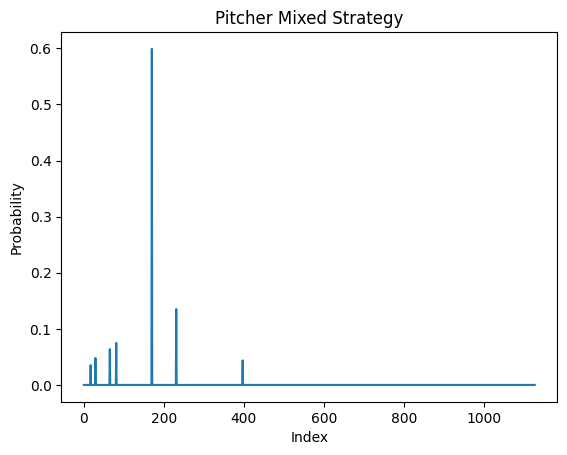

In [ ]:
plt.plot([i for i in range(len(pitcher_strat))], pitcher_strat)
plt.title('Pitcher Mixed Strategy')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.show()

In [ ]:
#get the tunnel location for the actual pitch to plot with the other tunnels 
actual_pitch = pa.loc[pa.pitch_number == 5]
actual_pitch[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(actual_pitch[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)

actual_pitch[['tunnel_x', 'tunnel_y', 'tunnel_z']] = trace_decision_trajectory(actual_pitch)

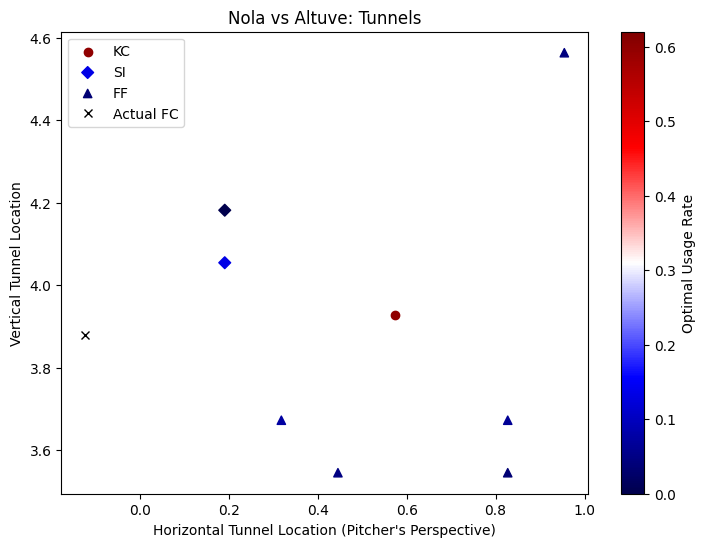

In [ ]:
#plot tunnels 
plt.figure(figsize = (8.5,6))
d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

ff = d.loc[d.pitch_type == 'FF']
si = d.loc[d.pitch_type == 'SI']
kc = d.loc[d.pitch_type == 'KC']
plt.scatter(-1*kc.tunnel_x.values, kc.tunnel_z.values, marker = 'o', label = 'KC', c = kc.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.62)
plt.scatter(-1*si.tunnel_x.values, si.tunnel_z.values, marker = 'D', label = 'SI', c = si.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.62)
c = plt.scatter(-1*ff.tunnel_x.values, ff.tunnel_z.values, marker = '^', label = 'FF', c = ff.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.62)
#plot the standard strize zone as well
#plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
#plot the actual pitch
plt.plot(-1*actual_pitch.tunnel_x.values[0], actual_pitch.tunnel_z.values[0], 'kx', label = "Actual FC")
plt.xlabel("Horizontal Tunnel Location (Pitcher's Perspective)")
plt.ylabel('Vertical Tunnel Location')
#plt.xlim(-1.5,1.5)
#plt.ylim(1,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
plt.legend()
plt.title("Nola vs Altuve: Tunnels")
plt.show()

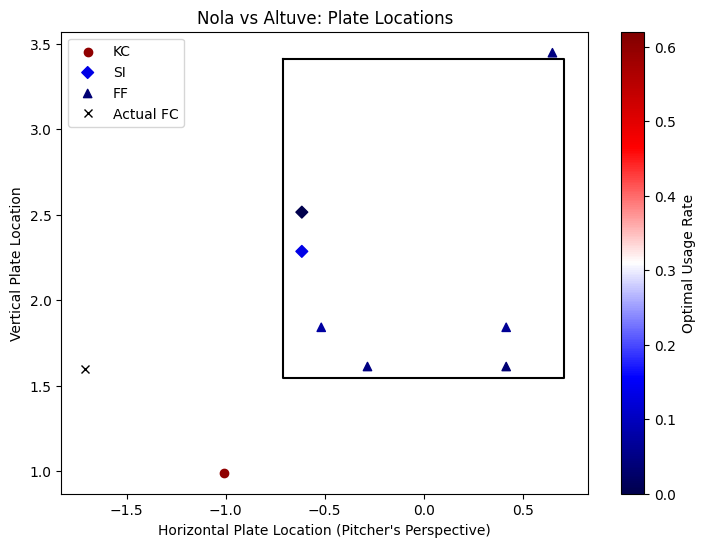

In [ ]:
#prettier plot for the paper 
plt.figure(figsize = (8.5,6))
d = pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

fc = d.loc[d.pitch_type == 'FF']
si = d.loc[d.pitch_type == 'SI']
sl = d.loc[d.pitch_type == 'KC']
plt.scatter(-1*sl.plate_x_ft.values, sl.plate_z_ft.values, marker = 'o', label = 'KC', c = sl.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.62)
plt.scatter(-1*si.plate_x_ft.values, si.plate_z_ft.values, marker = 'D', label = 'SI', c = si.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0, vmax = 0.62)
c = plt.scatter(-1*fc.plate_x_ft.values, fc.plate_z_ft.values, marker = '^', label = 'FF', c = fc.equilibrium_usage_rate.values, cmap = 'seismic', vmin = 0., vmax = 0.62)
#plot the standard strize zone as well
plt.plot([-.71,.71,.71,-.71, -.71], [3.412, 3.412, 1.546,1.546, 3.412], 'k-')
#plot the actual pitch 
plt.plot([-1.71], [1.6], 'kx', label = "Actual FC")
plt.xlabel("Horizontal Plate Location (Pitcher's Perspective)")
plt.ylabel('Vertical Plate Location')
#plt.xlim(-1.5,1.5)
#plt.ylim(1,4)
cbar = plt.colorbar(c)
cbar.set_label('Optimal Usage Rate')
plt.legend()
plt.title("Nola vs Altuve: Plate Locations")
plt.show()

In [ ]:
#strategy on actual pitch tunnel
dists = np.sqrt((igrid.tunnel_x.values - actual_pitch.tunnel_x.values[0])**2 + (igrid.tunnel_z.values - actual_pitch.tunnel_z.values[0])**2)
igrid['dist'] = dists 
min_dist = np.min(dists)
igrid.loc[igrid.dist == min_dist]

,release_speed,mx,mz,bat_handR,pit_handR,release_spin_rate,tunnel_x,tunnel_z,tunnel_index,batter_index,pitcher_id,pitch_type,balls,strikes,pfx_x,pfx_z,release_pos_x,release_pos_z,plate_x,plate_z,plate_x_ft,plate_z_ft,o0,o1,o2,o3,o4,o5,o6,o7,o8,swing_utility,take_utility,actual_run_value,dist
1316,-0.564678,-1.312852,-0.553330,1.0,1.0,-2.210908,0.063636,3.927273,1316,12,605400,CH,1,2,-1.262731,0.226940,-2.019948,4.956828,1.451032,-0.468076,1.267366,1.824292,0.691406,1.299353e-02,0.092106,0.098957,0.073972,0.026713,0.002964,2.689618e-04,6.195806e-04,-0.050683,0.041352,NaN,0.07628
4452,0.652467,-1.123810,0.795639,1.0,1.0,0.038711,0.063636,3.927273,1316,12,605400,FF,1,2,-1.097003,1.234171,-1.877483,5.090514,1.393158,0.018706,1.218526,2.300276,0.759131,2.274431e-02,0.035535,0.109137,0.050659,0.018027,0.003424,2.702628e-04,1.070960e-03,-0.011286,0.038669,NaN,0.07628
7588,-1.694540,1.498390,-2.029883,1.0,1.0,0.957934,0.063636,3.927273,1316,12,605400,KC,1,2,1.201812,-0.875553,-1.863126,5.195745,2.530805,-1.320778,2.178588,0.990506,0.936869,6.070486e-08,0.060270,0.002044,0.000653,0.000161,0.000003,3.783613e-08,1.128398e-07,-0.197277,0.046000,NaN,0.07628
10724,0.536255,-1.510598,0.191635,1.0,1.0,-0.200248,0.063636,3.927273,1316,12,605400,SI,1,2,-1.436090,0.783181,-1.886960,5.069065,1.232628,-0.231143,1.083054,2.055969,0.615005,2.137839e-01,0.013834,0.074685,0.056123,0.021638,0.003610,3.053526e-04,1.017014e-03,0.018035,-0.019003,NaN,0.07628


In [ ]:
batter_strat[2*1316:2*1316+2]

array([1.20358953e-06, 9.99998796e-01])

Not surprisingly, the optimal strategy on this pitch tunnel was pure take. Altuve swung. 

In [ ]:
#look at the tunnel on the previous pitch that Nola threw to see if this game has learned the tunneling strategy where a player throws two consecutive pitches in similar tunnels.
penultimate = pa.loc[pa.pitch_number == 4]
penultimate[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(penultimate[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)

penultimate[['tunnel_x', 'tunnel_y', 'tunnel_z']] = trace_decision_trajectory(penultimate)

In [ ]:
penultimate[['pitch_type', 'pitch_number', 'outcome', 'tunnel_x', 'tunnel_z', 'plate_x_ft', 'plate_z_ft']]

,pitch_type,pitch_number,outcome,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft
300,SI,4,3,-0.864305,3.9384,-0.7,2.16


In [ ]:
pitcher_df.loc[pitcher_df.equilibrium_usage_rate > 0]

,tunnel_index,pitch_type,equilibrium_usage_rate,tunnel_x,tunnel_z,plate_x_ft,plate_z_ft
21,1142,FF,0.056218,-0.700000,3.545455,-0.182818,1.611823
33,1145,FF,0.063117,-0.318182,3.545455,0.517854,1.611823
65,1197,FF,0.060252,-0.827273,3.672727,-0.416375,1.841307
81,1201,FF,0.043124,-0.318182,3.672727,0.517854,1.841307
170,1311,KC,0.615968,-0.572727,3.927273,1.010802,0.990506
231,1370,SI,0.113930,-0.190909,4.054545,0.615939,2.285453
235,1371,SI,0.014749,-0.063636,4.054545,0.849497,2.285453
393,1587,FF,0.004280,-1.081818,4.563636,-0.883490,3.447696
445,1644,FF,0.028347,-0.954545,4.690909,-0.649933,3.677180


#### **Testing Batter Optimality**

In [ ]:
#read in the skill estimates 
skill = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/pitcher_skill_estimates.csv')

skill.columns = ['pitcher', 'pitcher_name', 'avg', 'CH', 'CU', 'FC', 'FF', 'FS', 'KC', 'SI', 'SL']

In [ ]:
#get the usages for each of these pitchers 
non_z_scored = all_data.copy()
non_z_scored[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(non_z_scored[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)
pitch_usages = pd.DataFrame()
for pitcher in skill.pitcher.values:
  pdf = non_z_scored.loc[all_data.pitcher == pitcher]
  n = pdf.shape[0]
  usages = pdf.groupby('pitch_type', as_index = False).agg(N = ('is_swing', 'count'),
                                                           release_speed = ('release_speed', 'mean'),
                                                           mx = ('mx', 'mean'),
                                                           mz = ('mz', 'mean'),
                                                           pfx_x = ('pfx_x', 'mean'),
                                                           pfx_z = ('pfx_z', 'mean'),
                                                           release_spin_rate = ('release_spin_rate', 'mean'),
                                                           release_pos_x = ('release_pos_x', 'mean'),
                                                           release_pos_z = ('release_pos_z', 'mean'))
  usages.N = usages.N / n
  usages['pitcher_id'] = pitcher
  pitch_usages = pitch_usages.append(usages, ignore_index = True)

pitch_usages = pitch_usages.loc[pitch_usages.N >= 0.05]

In [ ]:
#define a dictionary of execution score dictionaries for each pitcher 
execution_scores = dict()
for pitcher in skill.pitcher.values:
  pitches = pitch_usages.loc[pitch_usages.pitcher_id == pitcher]
  pitcher_skill = skill.loc[skill.pitcher == pitcher]
  pitch_dict = dict()
  for p in pitches.pitch_type.values:
    pitch_dict.update({p: pitcher_skill[[p]].values[0]})
  
  execution_scores.update({pitcher: pitch_dict})

In [ ]:
#we need the batters we're going to test on. Identify the top 3 most faced batters in the data for each pitcher
test_data = pd.DataFrame()
matchup_N = pd.DataFrame()
for pitcher in skill.pitcher.values:
  pitcher_data = train.loc[train.pitcher == pitcher]
  pitcher_data = pitcher_data.loc[(pitcher_data.balls == 0) & (pitcher_data.strikes == 0)]
  top_batters = pitcher_data.groupby([ 'batter_index', 'batter', 'bat_handR', 'pit_handR'], as_index = False).agg(N = ('pa_id', 'count'))
  top_batters.sort_values(by = 'N', ascending = False, inplace = True)
  for i in range(3):
    new_data = pitcher_data.loc[pitcher_data.batter_index == top_batters.batter_index.values[i]]
    new_data['N'] = top_batters.N.values[i]
    test_data = test_data.append(new_data)
  top_batters['pitcher'] = pitcher
  matchup_N = matchup_N.append(top_batters[:3])

In [ ]:
#run the model on test_data so you can get a utility and run value
x = torch.tensor(test_data[features].values.astype(float), dtype = torch.float).to(device)
y = torch.tensor(test_data.outcome.values.astype(int), dtype = torch.long).to(device)

h = model.init_hidden().to(device) 
h = h.repeat(x.size(0), 1)

preds = nn.functional.softmax(model.input_embedding(x, h), dim = 1)
test_data[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = preds.detach().cpu().numpy()

test_data = get_utilities(test_data)

In [ ]:
#define a function that takes as input a batter and pitcher and solves for the optimal pitcher and batter strategy in just the 0-0 count

def first_pitch_strategy(batter_idx, pitcher, bhand, phand):
  #define the initial grid 
  igrid = initial_grid(batter_idx, pitcher, model.init_hidden().to(device), bhand = bhand,phand = phand, balls = 0, strikes = 0)

  #now get the A matrix for this game 
  pitches = pitch_usages.loc[pitch_usages.pitcher_id==pitcher, 'pitch_type'].unique()
  tunnel_indices = igrid.loc[(igrid.plate_x_ft >= -1.5) & (igrid.plate_x_ft <= 1.5) & (igrid.plate_z_ft >= 1) & (igrid.plate_z_ft <= 4), 'tunnel_index'].unique()
  execution_score =  execution_scores[pitcher]

  #initialize A
  A = get_A_for_tunnel(igrid, tunnel_indices[0], pitches[0], 0.6)
  for t in tunnel_indices:
    for p in pitches:
      A = np.vstack((A, get_A_for_tunnel(igrid, t, p, execution_score[p])))
  A = A[1:,:]

  #solve for the batter and pitcher strategies
  batter_strat, pitcher_strat, util = get_strategies(A)

  return batter_strat, pitcher_strat


In [ ]:
#this solution takes much longer to find, so we're just going to use the 10 matchups with the most data 
solvers.options['show_progress'] = False 
matchups = matchup_N.sort_values(by='N', ascending = False).head(10)
batter_strats = dict()
pitcher_strats = dict()
for i in range(matchups.shape[0]):
  pitcher = matchups.pitcher.values[i] 
  batter = matchups.batter_index.values[i]
  bathand = matchups.bat_handR.values[i]
  pithand = matchups.pit_handR.values[i]
  #get the strategies 
  bs, ps = first_pitch_strategy(batter, pitcher, bathand, pithand)
  batter_strats.update({i: bs})
  pitcher_strats.update({i:ps})
  print('finished a matchup')


Status: optimal
finished a matchup
Status: optimal
finished a matchup
Status: optimal
finished a matchup
Status: optimal
finished a matchup
Status: optimal
finished a matchup
Status: optimal
finished a matchup
Status: optimal
finished a matchup
Status: optimal
finished a matchup
Status: optimal
finished a matchup
Status: optimal
finished a matchup


In [ ]:
#we also need the tunnel indices for all these pitchers 
tunnel_x, tunnel_z = np.meshgrid(np.linspace(-3.5,3.5, int(7*12/1.5)), np.linspace(1,8,int(7*12/1.5))) 
tunnel_x = tunnel_x.flatten()
tunnel_z = tunnel_z.flatten()
grid_size = len(tunnel_x)
#define a tunnel location index 
tunnel_index = np.arange(grid_size)
tunnels_key = pd.DataFrame({'tunnel_index': tunnel_index, 'tunnel_x': tunnel_x, 'tunnel_z':tunnel_z})

In [ ]:
#now, we need all of the first pitches of the plate appearance for the matchups we looked at
td = pd.DataFrame()
for i in range(matchups.shape[0]):
  batter = matchups.batter_index.values[i]
  pitcher = matchups.pitcher.values[i]
  td = td.append(test_data.loc[(test_data.batter_index == batter) & (test_data.pitcher == pitcher)])

In [ ]:
#now we need the tunnel location for each of these pitches
tunnel_x = []
tunnel_z = []
td[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.inverse_transform(td[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)

for i in range(td.shape[0]):
  x,y,z = trace_decision_trajectory(td.iloc[[i]])
  tunnel_x.append(x)
  tunnel_z.append(z)

td['tunnel_z'] = tunnel_z
td['tunnel_x'] = tunnel_x

In [ ]:
#now get the recommended batter strategy for each tunnel, and if it is a pure strategy, see if the batter actually used that strategy 
final_data = pd.DataFrame()
for i in range(matchups.shape[0]):
  pitcher = matchups.pitcher.values[i] 
  batter = matchups.batter_index.values[i]
  ps = pitcher_strats[i] 
  bs = batter_strats[i]
  ct = tunnels_key.copy()
  d = td.loc[(td.batter_index == batter) & (td.pitcher == pitcher)]
  tis = []
  distances = [] 
  batter_optimal_strategies = []
  for j in range(d.shape[0]):
    #get the tunnel location for this specific pitch 
    tunnel_x_spec, tunnel_z_spec = d[['tunnel_x', 'tunnel_z']].values[j]

    #find the tunnel that that is closest to in the pitcher's tunnels 
    dists = np.sqrt((ct.tunnel_x.values - tunnel_x_spec)**2 + (ct.tunnel_z.values - tunnel_z_spec)**2)
    min_dist = np.min(dists)
    ct['dist'] = dists 
    ti = ct.loc[ct.dist == min_dist, 'tunnel_index'].values[0]

    #get the batter strategy for that tunnel 
    bat_strat = bs[ti*2:2*ti+2]
    #check if it is relatively pure 
    if bat_strat[0] >0.98 or bat_strat[1] > 0.98:
      #first action is swing, second is take
      bat_strat_is_swing = 1- np.argmax(bat_strat) 
    else:
      bat_strat_is_swing = np.nan 

    tis.append(ti)
    distances.append(min_dist)
    batter_optimal_strategies.append(bat_strat_is_swing)

  d['tunnel_index'] = tis 
  d['distance'] = distances 
  d['batter_strategy_is_swing'] = batter_optimal_strategies 
  final_data = final_data.append(d)
    

In [ ]:
#remove data where the closest tunnel isn't that close (3 inches)
final_data = final_data.loc[final_data.distance < 3/12]

#remove data where the strategy wasn't pure for the batter 
final_data = final_data.loc[np.isnan(final_data.batter_strategy_is_swing) == False]

In [ ]:
final_data['batter_correct_action'] = final_data.is_swing == final_data.batter_strategy_is_swing

In [ ]:
final_data.batter_correct_action.mean(), final_data.shape[0]

(0.7058823529411765, 255)

In [ ]:
from scipy.stats import ttest_ind
right = final_data.loc[final_data.batter_correct_action == True]
wrong = final_data.loc[final_data.batter_correct_action == False]
right.actual_run_value.mean(), wrong.actual_run_value.mean(), ttest_ind(right.actual_run_value.values, wrong.actual_run_value.values, equal_var = False, alternative = 'greater')

(0.0025277777777777794,
 -0.012426666666666655,
 Ttest_indResult(statistic=0.566316980910856, pvalue=0.2861979886727596))

Just like we saw in the Stackelberg game, it is once again true that batter's don't always make the optimal decision, which is obviously an important assumption in game theory. At least in this case they seem to be more able to behave optimally, at 71\% instead of 47\% in the other game. 

In [ ]:
batter_results = final_data.groupby("batter", as_index = False).agg(n = ('is_swing', 'count'),
                                                                  correct_decision_rate = ('batter_correct_action', 'mean'),
                                                                  avg_run_value_actual_outcomes = ('actual_run_value', 'mean'))

In [ ]:
batter_results.sort_values(by='correct_decision_rate', ascending = False)

,batter,n,correct_decision_rate,avg_run_value_actual_outcomes
2,608324,22,0.772727,-0.019864
5,650490,22,0.772727,-0.022682
9,666182,25,0.760000,0.045200
0,493329,20,0.750000,0.052200
4,646240,28,0.750000,-0.010000
7,660271,22,0.727273,0.005227
1,596019,26,0.692308,-0.005154
8,663586,33,0.666667,-0.034576
6,657077,26,0.615385,-0.022846
3,621020,31,0.612903,0.010290


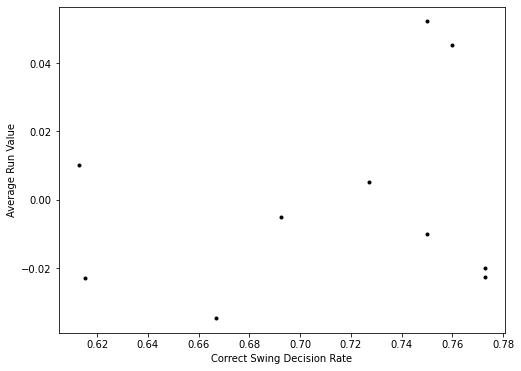

Correlation: 0.25427824161013385


In [ ]:
#plot the actual utility compared to the percentage of correct decisions
plt.figure(figsize = (8,6))
plt.plot(batter_results.correct_decision_rate.values, batter_results.avg_run_value_actual_outcomes.values, 'k.')
plt.xlabel('Correct Swing Decision Rate')
plt.ylabel('Average Run Value')
plt.show()
print('Correlation: ' +  str(np.corrcoef(batter_results.correct_decision_rate.values, batter_results.avg_run_value_actual_outcomes.values)[0,1]))

Weak positive correlation. Really small sample size obviously. If I had more time I might run more matchups. 

In [ ]:
matchups

,batter_index,batter,bat_handR,pit_handR,N,pitcher
55,86,663586,1,1,35,605400
49,80,621020,1,1,34,605400
89,169,646240,0,1,28,543037
69,103,596019,0,1,26,605400
64,123,666182,1,1,26,543037
82,161,657077,0,1,26,543037
15,18,493329,1,0,23,527048
115,244,660271,0,1,22,641540
70,112,650490,1,0,22,592662
4,5,608324,1,0,22,527048
